# Financial Data Analysis and Visualization of Loan Applications for Bank X
##### Made with ❤ by : Abercha Zineb, Aitmagourt Adnane, Arnaoui Basma, Anass Kemmoune

## A-Introduction

In the world of finance, where data plays a big role, being able to look at and understand data is really important for making decisions. This project is all about using a lot of information from "Bank X" to find out more about loan applications. We want to see different parts of financial info, like loan applications, credit history, and how people pay back loans. The goal is to find patterns and connections that can make it easier for "Bank X" to decide who can get a loan.

#### Finding Financial Insights

We're going through this data in a careful way:

1. **Putting Data Together:** Mixing different sets of data to get a full picture.
2. **Looking at Data Closely:** Finding hidden trends and things that are different.
3. **Making Pictures:** Creating helpful charts to understand things better.

Each step is made to build on the one before, so we really get why loans are approved and how people handle money. This notebook is like a big document that talks about how we did things, what we found, and what it means for "Bank X."

#### Goals

- Give answers based on data to help make better choices.
- Enhance the loan approval process.

Through all of this, our aim is not just to solve problems with data but also to show how using data can be a good strategy in finance.


## B-Imports :

In [1]:
import helperfunctions as hf
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pdcast as pdc   # Firstly you should run 'pip install pandas-downcast'
import textwrap  # Import the textwrap module

## C-Helper Functions :

### 1-General use Functions

In [2]:

def is_unique_key(df : pd.DataFrame ,columnName : str) :

    """Function to check if column is a primary key in the given dataframe    
    returns true if the entry is primary key, false otherwise
    """

    x = df.shape[0]
    l = df[columnName].drop_duplicates().shape[0]

    return x == l  

def last(x) : 
    """Function to get the last in the DataFrame"""

    return x.iloc[-1] 

def modify_labels(original_column, labels):
    """Function to modify column names"""
    result = []
    # Define lambda functions to clarify the column names
    col_split = lambda x: x.get_text().split(original_column + '_')
    modify_name = lambda x: col_split(x)[0][1:] + col_split(x)[-1][:-1]
    for label in labels:
        new = modify_name(label)
        result.append(new)
    return result


### 2-Optimization Functions

In [3]:
def df_optimize(df) :
        """Function to down cast pandas entries types into smaller versions in order to optimize space in the used dataframes
    returns the resulting dataframe
    """
        
        df = pdc.downcast(df)
        return df 

def df_optimize_path(df_path :str) :

    """Function to down cast pandas entries types into smaller versions in order to optimize space in the used dataframes
    returns the resulting dataframe
    """
 
    df = pd.read_csv(df_path)
    a =  df.memory_usage().sum()
    df = pdc.downcast(df)
    b = df.memory_usage().sum()
    print("Memory saved by : " ,((1-b/a) * 100),"%")
    
    return df


### 3-Aggregation Functions

#### - General Aggregations

In [4]:
def df_aggreg(df ,on ,aggreg_dict) : 
     """Function to do an aggregation on Dataframe columns on a specific function given in the aggreg_dict"""
     df = df.groupby(on).agg(aggreg_dict).reset_index()
     df.columns = [f'{col[0]}_{col[1].lower()}' if isinstance(col, tuple) else col.lower() for col in df.columns]
     df.rename(columns = {"sk_id_prev_": "sk_id_prev", "sk_id_curr_first" : "sk_id_curr","sk_id_curr_" : "sk_id_curr","sk_id_bureau_":"sk_id_bureau"},inplace=True)
     return df
     

def df_aggreg2(df : pd.DataFrame ,df_rename) : 

    """Function to perform an aggregation function on the DataFrame in order to have unique ids"""
    
    df_count = df[['sk_id_curr', 'sk_id_prev']].groupby('sk_id_curr').count()


    df['sk_id_prev'] = df['sk_id_curr'].map(df_count['sk_id_prev'])

    df_avg = df.groupby('sk_id_curr').mean()

    #Renaming columns

    df_avg.columns = [df_rename +'_' + col for col in df_avg.columns]


    return df_avg

#### - Previous Credits aggregation

In [5]:
def previous_credits_aggreg(df : pd.DataFrame) :

    """Function to perform an aggregation function on the DataFrame in order to have unique ids"""

    #group by id and perform an aggregation function to have unique ids
    df_avg = df.groupby('sk_id_curr').mean()
    df_avg['p_count'] = df[['sk_id_bureau','sk_id_curr']].groupby('sk_id_curr').count()['sk_id_bureau']
    #Rename columns
    df_avg.columns = ['previous_credits_' + col for col in df_avg.columns]
    return df_avg   

def previous_credits_aggreg_with_curr(df : pd.DataFrame) :

    """Function to perform an aggregation function on the DataFrame in order to have unique ids"""

    #group by id and perform an aggregation function to have unique ids
    df_avg = df.groupby('sk_id_curr').mean()
    df_avg['p_count'] = df[['sk_id_bureau','sk_id_curr']].groupby('sk_id_curr').count()['sk_id_bureau']
    #Rename columns
    df_avg.columns = ['previous_credits_' + col for col in df_avg.columns]
    df_avg['sk_id_curr'] = df_avg.index
    return df_avg 

#### - Credit Bureau Balance Aggregation

In [6]:
def credit_bureau_balance_aggreg(df : pd.DataFrame) :

    """Function to perform an aggregation function on the DataFrame in order to have unique ids"""

    #group by id and perform an aggregation function to have unique ids
    df_count = df['sk_id_bureau'].groupby('sk_id_bureau').count()


    df['sk_id_bureau'] = df['sk_id_bureau'].map(df_count['sk_id_bureau'])

    df_avg = df.groupby('sk_id_bureau').mean()

    #Renaming columns

    df_avg.columns = ['credit_bureau_balance_' + col for col in df_avg.columns]
    return df_avg      

### 4-Sections loading & Full merge Functions

#### - Section 1

In [7]:
def getSection1() :
    """Funtion to generate Section 1 as used in the merge previously"""

    section1 = df_optimize_path("Dataset/loan_applications_train.csv")
    section1 = pd.get_dummies(section1, columns=section1.select_dtypes(include=['category']).columns)
    print("Section 1 Loaded")
    
    return section1

#### - Section 2

In [8]:
def getSection2() :
    """Funtion to generate Section 2 as used in the merge previously"""

    # Loading data
    previous_pos_cash_loans=df_optimize_path("Dataset/previous_POS_cash_loans.csv")
    previous_credit_cards=df_optimize_path("Dataset/previous_credit_cards.csv")
    previous_loan_applications=df_optimize_path("Dataset/previous_loan_applications.csv")
    repayment_history=df_optimize_path("Dataset/repayment_history.csv")


    #Converting categorical variable into dummy variables.
    previous_pos_cash_loans = pd.get_dummies(previous_pos_cash_loans, columns=previous_pos_cash_loans.select_dtypes(include=['category']).columns)
    previous_credit_cards = pd.get_dummies(previous_credit_cards, columns=previous_credit_cards.select_dtypes(include=['category']).columns)
    previous_loan_applications = pd.get_dummies(previous_loan_applications, columns=previous_loan_applications.select_dtypes(include=['category']).columns)
    repayment_history = pd.get_dummies(repayment_history, columns=repayment_history.select_dtypes(include=['category']).columns)

    #Groupby and Aggregation
    previous_credit_cards = df_aggreg2(previous_credit_cards,"previous_credit_cards")
    previous_pos_cash_loans = df_aggreg2(previous_pos_cash_loans,"previous_pos_cash_loans")
    previous_loan_applications = df_aggreg2(previous_loan_applications,"previous_pos_cash_loans")
    repayment_history = df_aggreg2(repayment_history,"repayment_history")



    #Inplace merging
    section2 = pd.merge( previous_loan_applications,previous_credit_cards ,on = "sk_id_curr",how = "left")
    section2 = pd.merge(section2,previous_pos_cash_loans ,on="sk_id_curr",how="left")
    section2 = pd.merge(section2,repayment_history,on="sk_id_curr",how='left')

    print("Section 2 Loaded")


    return section2

#### - Section 3

In [9]:
def getSection3() :
    """Funtion to generate Section 3 as used in the merge previously"""


    # Loading data
    previous_credits = df_optimize_path("Dataset/previous_credits.csv")
    credit_bureau_balance=df_optimize_path("Dataset/credit_bureau_balance.csv")

    previous_credits = pd.get_dummies(previous_credits, columns=previous_credits.select_dtypes(include=['category']).columns)
    credit_bureau_balance = pd.get_dummies(credit_bureau_balance, columns=credit_bureau_balance.select_dtypes(include=['category']).columns)

    #Converting categorical variable into dummy variables.
    aggregations_credit_bureau_balance = {
        'sk_id_bureau' : 'first',
        'months_balance': ['min', 'max'],
        'status_0': 'last',
        'status_1': 'last',
        'status_2': 'last',
        'status_3': 'last',
        'status_4': 'last',
        'status_5': 'last',
        'status_C': 'last',
        'status_X': 'last'
    }
    credit_bureau_balance = df_aggreg(credit_bureau_balance,'sk_id_bureau',aggregations_credit_bureau_balance)
    previous_credits = previous_credits_aggreg_with_curr(previous_credits)

    #Inplace merging
    
    previous_credits=previous_credits.rename(columns={"previous_credits_sk_id_bureau" : "sk_id_bureau"})
    section3 = pd.merge(previous_credits,credit_bureau_balance,on="sk_id_bureau",how="left")


    print("Section 3 Loaded")


    return section3


#### - Full merge

In [10]:
def full_merge(section1 , section2 , section3) : 
    """Function to merge the Sections"""

    section1_2 = pd.merge(section1, section2, on='sk_id_curr', how='left')
    print("Section 1 and 2 merged")

    full = pd.merge(section1_2, section3, on='sk_id_curr', how='left')

    print("Section 1, 2 and 3 merged")
    return full


## D- Sections loading and Full merge 
#### (applied from helper functions defined before)

### 1- Section Loading

In [11]:
section1 = getSection1()
section2 = getSection2()
section3 = getSection3()

c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


Memory saved by :  68.95278329052113 %
Section 1 Loaded
Memory saved by :  71.87492706070144 %


c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\

Memory saved by :  61.412981625109396 %


c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


Memory saved by :  68.57983376450875 %


c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


Memory saved by :  62.499990525363394 %
Section 2 Loaded


c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
c:\Users\Student\AppData\Local\Programs\

Memory saved by :  60.29361918216489 %
Memory saved by :  74.99992933437443 %


C:\Users\Student\AppData\Local\Temp\ipykernel_6788\156549502.py:31: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  section3 = pd.merge(previous_credits,credit_bureau_balance,on="sk_id_bureau",how="left")


Section 3 Loaded


### 2- Full merge

In [12]:
full = full_merge(section1,section2,section3)
full

Section 1 and 2 merged
Section 1, 2 and 3 merged


sk_id_curr  target  cnt_children  amt_income_total  amt_credit  \
0           100002    True             0          202500.0    406597.5   
1           100003   False             0          270000.0   1293502.5   
2           100004   False             0           67500.0    135000.0   
3           100006   False             0          135000.0    312682.5   
4           100007   False             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
307506      456251   False             0          157500.0    254700.0   
307507      456252   False             0           72000.0    269550.0   
307508      456253   False             0          153000.0    677664.0   
307509      456254    True             0          171000.0    370107.0   
307510      456255   False             0          157500.0    675000.0   

        amt_annuity  amt_goods_price  region_population_relative  days_birth  \
0           24700.5         351000.0                    0.018801       -9461   
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
307506      27558.0         225000.0                    0.032561       -9327   
307507      12001.5         225000.0                    0.025164      -20775   
307508      29979.0         585000.0                    0.005002      -14966   
307509      20205.0         319500.0                    0.005313      -11961   
307510      49117.5         675000.0                    0.046220      -16856   

        days_employed  ...  months_balance_min  months_balance_max  \
0                -637  ...                 NaN                 NaN   
1               -1188  ...                 NaN                 NaN   
2                -225  ...                 NaN                 NaN   
3               -3039  ...                 NaN                 NaN   
4               -3038  ...                 NaN                 NaN   
...               ...  ...                 ...                 ...   
307506           -236  ...                 NaN                 NaN   
307507         365243  ...                 NaN                 NaN   
307508          -7921  ...                 NaN                 NaN   
307509          -4786  ...               -36.0                 0.0   
307510          -1262  ...               -12.0                 0.0   

        status_0_last  status_1_last  status_2_last  status_3_last  \
0                 NaN            NaN            NaN            NaN   
1                 NaN            NaN            NaN            NaN   
2                 NaN            NaN            NaN            NaN   
3                 NaN            NaN            NaN            NaN   
4                 NaN            NaN            NaN            NaN   
...               ...            ...            ...            ...   
307506            NaN            NaN            NaN            NaN   
307507            NaN            NaN            NaN            NaN   
307508            NaN            NaN            NaN            NaN   
307509           True          False          False          False   
307510          False          False          False          False   

        status_4_last  status_5_last  status_C_last  status_X_last  
0                 NaN            NaN            NaN            NaN  
1                 NaN            NaN            NaN            NaN  
2                 NaN            NaN            NaN            NaN  
3                 NaN            NaN            NaN            NaN  
4                 NaN            NaN            NaN            NaN  
...               ...            ...            ...           

## E- Exploratory Data Analysis for each section (EDA)

### 1-EDA on Section 1

#### - General informations on Section 1

In [13]:
# Count of missing values for each column in the 'section1' DataFrame

print(section1.isna().sum())

sk_id_curr                         0
target                             0
cnt_children                       0
amt_income_total                   0
amt_credit                         0
                                  ..
wallsmaterial_mode_Panel           0
wallsmaterial_mode_Stone, brick    0
wallsmaterial_mode_Wooden          0
emergencystate_mode_No             0
emergencystate_mode_Yes            0
Length: 246, dtype: int64


In [14]:
# Display a concise summary of the 'section1' DataFrame

section1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 246 entries, sk_id_curr to emergencystate_mode_Yes
dtypes: Int16(1), UInt16(3), UInt8(9), bool(173), float32(52), int16(2), int32(1), uint32(1), uint8(4)
memory usage: 125.2 MB


In [15]:
# Generate descriptive statistics for the 'section1' DataFrame

section1.describe()

sk_id_curr   cnt_children  amt_income_total    amt_credit  \
count  307511.000000  307511.000000      3.075110e+05  3.075110e+05   
mean   278180.518577       0.417052      1.687979e+05  5.990259e+05   
std    102790.175348       0.722121      2.371231e+05  4.024908e+05   
min    100002.000000       0.000000      2.565000e+04  4.500000e+04   
25%    189145.500000       0.000000      1.125000e+05  2.700000e+05   
50%    278202.000000       0.000000      1.471500e+05  5.135310e+05   
75%    367142.500000       1.000000      2.025000e+05  8.086500e+05   
max    456255.000000      19.000000      1.170000e+08  4.050000e+06   

         amt_annuity  amt_goods_price  region_population_relative  \
count  307499.000000     3.072330e+05               307511.000000   
mean    27108.572266     5.383961e+05                    0.020868   
std     14493.737305     3.694465e+05                    0.013831   
min      1615.500000     4.050000e+04                    0.000290   
25%     16524.000000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34596.000000     6.795000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          days_birth  days_employed  days_registration  ...  \
count  307511.000000  307511.000000      307511.000000  ...   
mean   -16036.995067   63815.045904       -4986.120117  ...   
std      4363.988632  141275.766519        3522.886230  ...   
min    -25229.000000  -17912.000000      -24672.000000  ...   
25%    -19682.000000   -2760.000000       -7479.500000  ...   
50%    -15750.000000   -1213.000000       -4504.000000  ...   
75%    -12413.000000    -289.000000       -2010.000000  ...   
max     -7489.000000  365243.000000           0.000000  ...   

       def_30_cnt_social_circle  obs_60_cnt_social_circle  \
count                  306490.0                  306490.0   
mean                   0.143421                  1.405292   
std                    0.446698                  2.379803   
min                         0.0                       0.0   
25%                         0.0                       0.0   
50%                         0.0                       0.0   
75%                         0.0                       2.0   
max                        34.0                     344.0   

       def_60_cnt_social_circle  days_last_phone_change  \
count                  306490.0                307510.0   
mean                   0.100049             -962.858788   
std                    0.362291              826.808487   
min                         0.0                 -4292.0   
25%                         0.0                 -1570.0   
50%                         0.0                  -757.0   
75%                         0.0                  -274.0   
max                        24.0                     0.0   

       amt_req_credit_bureau_hour  amt_req_credit_bureau_day  \
count                    265992.0                   265992.0   
mean                     0.006402                      0.007   
std                      0.083849                   0.110757   
min                           0.0                        0.0   
25%                           0.0                        0.0   
50%                           0.0                        0.0   
75%                           0.0                        0.0   
max                           4.0                        9.0   

       amt_req_credit_bureau_week  amt_req_credit_bureau_mon  \
count                    265992.0                   265992.0   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                           0.0                        0.0   
25%                           0.0                        0.0   
50%                           0.0                        0.0   
75%                           0.0                        0.0   
max      

In [16]:
# General information on Missing Values

check_null = section1.isna().sum().sort_values(ascending=False)
percentage = ((section1.isnull().sum()/len(section1)*100)).sort_values(ascending=False)
isna_train = pd.concat([check_null, percentage], axis=1, keys=['Count','Percentage'])
print('Count and percentage of missing values:')
isna_train.head(20)

Count and percentage of missing values:


Count  Percentage
commonarea_mode           214865   69.872297
commonarea_avg            214865   69.872297
commonarea_medi           214865   69.872297
nonlivingapartments_avg   213514   69.432963
nonlivingapartments_mode  213514   69.432963
nonlivingapartments_medi  213514   69.432963
livingapartments_mode     210199   68.354953
livingapartments_avg      210199   68.354953
livingapartments_medi     210199   68.354953
floorsmin_medi            208642   67.848630
floorsmin_mode            208642   67.848630
floorsmin_avg             208642   67.848630
years_build_medi          204488   66.497784
years_build_mode          204488   66.497784
years_build_avg           204488   66.497784
own_car_age               202929   65.990810
landarea_avg              182590   59.376738
landarea_medi             182590   59.376738
landarea_mode             182590   59.376738
basementarea_medi         179943   58.515956

#### - Distrubtion of target

Text(0.5, 1.0, 'Distribution of target')

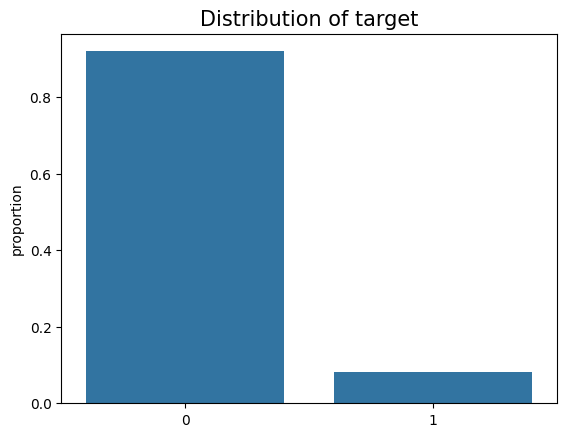

In [17]:

sb.barplot(x=[0,1], y=section1['target'].value_counts(normalize=True))
plt.title('Distribution of target', fontsize=15)

#### - Distrubtion of Clients Age

Text(0.5, 1.0, 'Distribution of Clients Age')

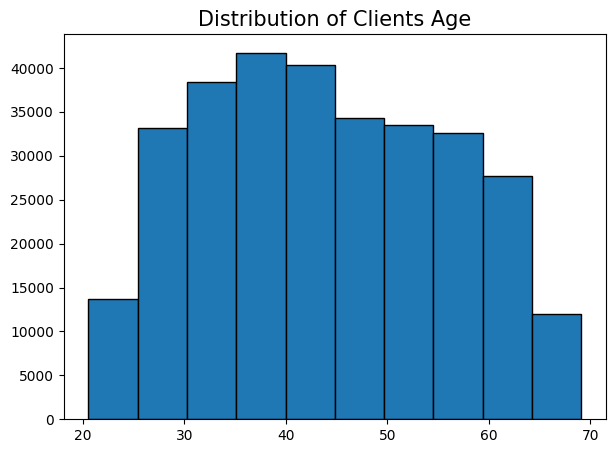

In [18]:
# Distribution of Clients Age
fig = plt.figure(figsize=(7,5))
plt.hist(section1['days_birth']/-365, edgecolor = 'black')
plt.title('Distribution of Clients Age', fontsize=15)

#### - Heatmap of correlations

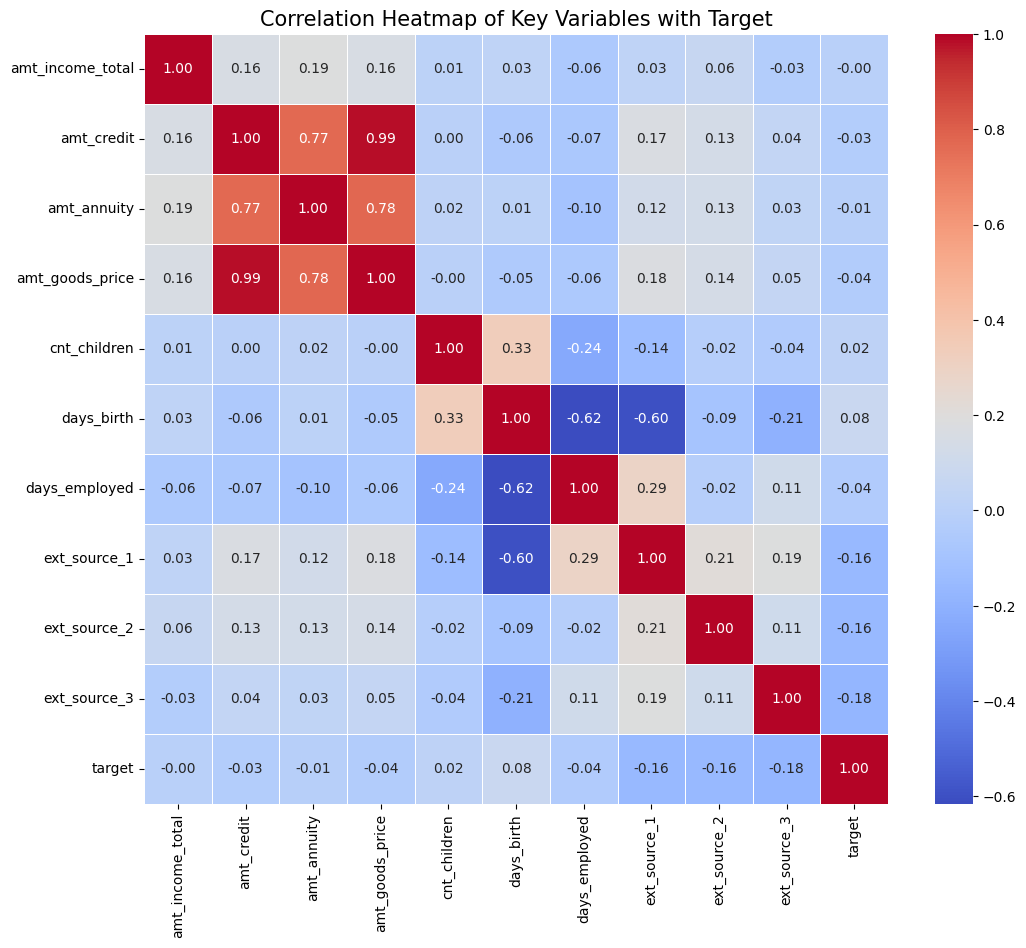

In [19]:
key_columns = [
    'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price',
    'cnt_children', 'days_birth', 'days_employed',
    'ext_source_1', 'ext_source_2', 'ext_source_3', 'target'
]

# Creating a correlation matrix for the selected columns
correlation_matrix = section1[key_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Key Variables with Target', fontsize=15)
plt.show()

#### - Client Repayment abilities

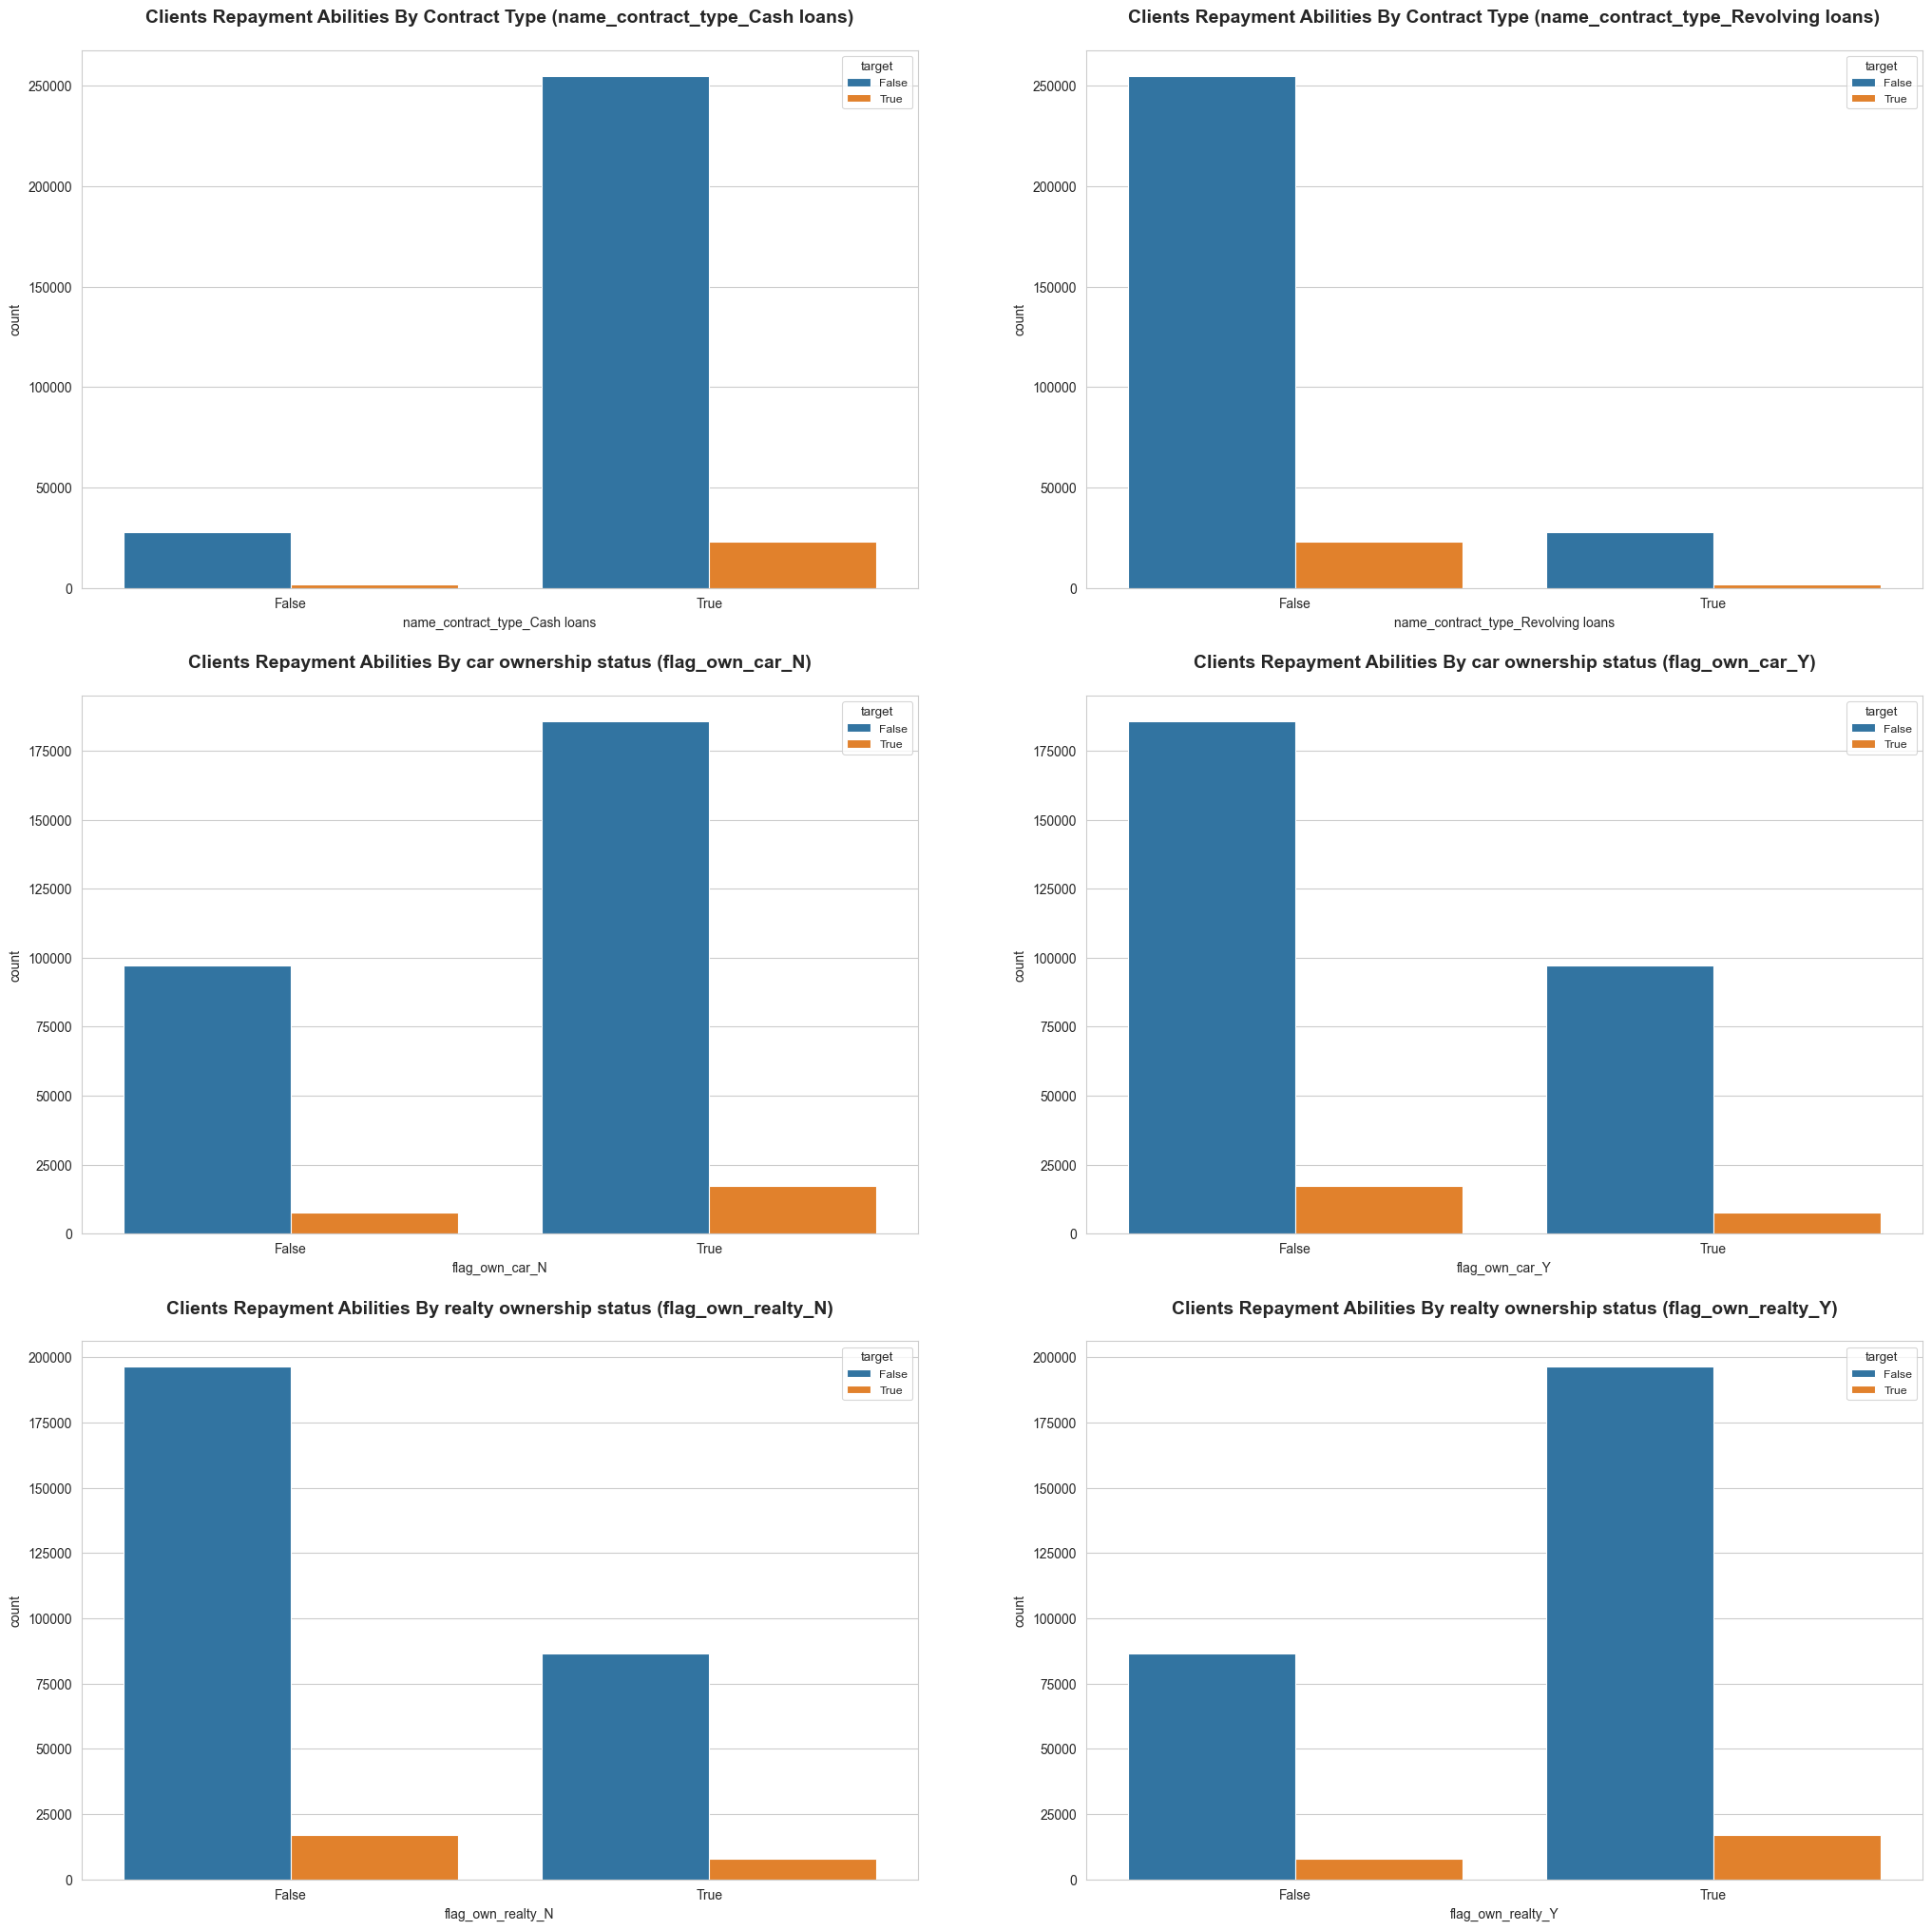

In [20]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style('whitegrid')
fig, ax = plt.subplots(3, 2, figsize=(25, 25))
sb.set_context('paper', font_scale=1)

# Assuming 'section1' is your DataFrame

# Get all columns starting with 'name_contract_type_'
name_contract_type_columns = [col for col in section1.columns if col.startswith('name_contract_type_')]
flag_own_car_columns = [col for col in section1.columns if col.startswith('flag_own_car_')]
flag_own_realty_columns = [col for col in section1.columns if col.startswith('flag_own_realty_')]


# Iterate through name_contract_type_columns
for i, column in enumerate(name_contract_type_columns):  # Display only the first two columns
    row = i // 2
    col = i % 2
    ax[row][col].set_title(f'Clients Repayment Abilities By Contract Type ({column})\n', fontweight='bold', fontsize=14)
    sb.countplot(x=column, data=section1, hue='target', ax=ax[row][col])

for i, column in enumerate(flag_own_car_columns):  # Display only the first two columns
    row = (i + len(name_contract_type_columns) ) // 2
    col = (i + len(name_contract_type_columns) ) % 2
    ax[row][col].set_title(f'Clients Repayment Abilities By car ownership status ({column})\n', fontweight='bold', fontsize=14)
    sb.countplot(x=column, data=section1, hue='target', ax=ax[row][col])

for i, column in enumerate(flag_own_realty_columns):  # Display only the first two columns
    row = (i + len(flag_own_car_columns) + len(name_contract_type_columns)) // 2
    col = (i + len(flag_own_car_columns) + len(name_contract_type_columns)) % 2
    ax[row][col].set_title(f'Clients Repayment Abilities By realty ownership status ({column})\n', fontweight='bold', fontsize=14)
    sb.countplot(x=column, data=section1, hue='target', ax=ax[row][col])


plt.show()

#### - Code gender in relationship with target

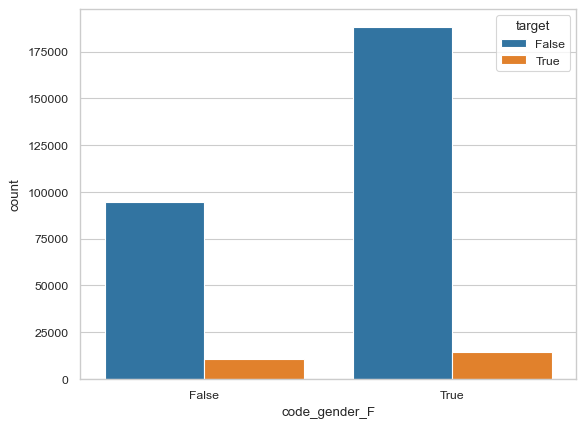

In [21]:

data = section1.copy()
data = data[["code_gender_F", "target"]]
data["code_gender_F"] = data["code_gender_F"].map({"Female": True, "False": "Male"})
sb.countplot(x ="code_gender_F" ,data=section1, hue='target')
plt.show()

#### - Percentage of employed & unemployed

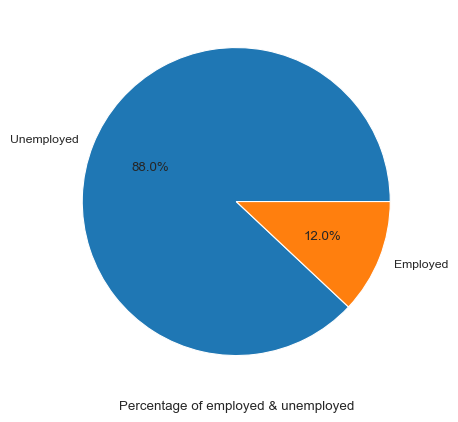

In [22]:
count_unemployed = section1.loc[(section1['target'] == 1) & (section1['days_employed'] <= 0)].count()['sk_id_curr']
count_employed = section1.loc[(section1['target'] == 1) & (section1['days_employed'] > 0)].count()['sk_id_curr']
total_all = section1.loc[(section1['target'] == 1)].count()['sk_id_curr']

data = {
    "Unemployed":round(count_unemployed/total_all*100),
    "Employed":round(count_employed/total_all*100)
}
# Creating plot

fig = plt.figure(figsize =(8, 5))
x=data.values()
y=data.keys()
plt.pie(x, labels = y, autopct='%1.1f%%')
  
# show plot
plt.xlabel('Percentage of employed & unemployed')
plt.show()

#### - Repayment Abilities

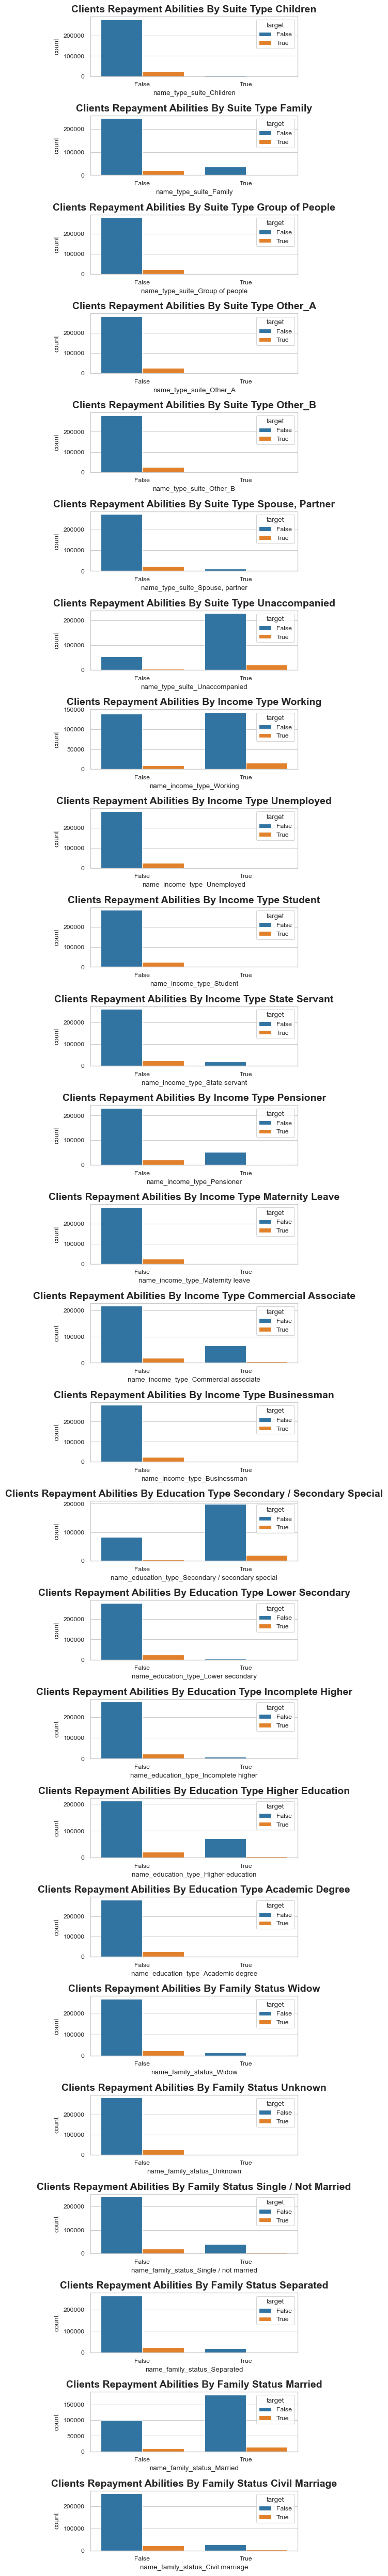

In [23]:
sb.set_style('whitegrid')
fig, ax = plt.subplots(26, 1, figsize=(5, 50))  # 26 rows, 1 column
sb.set_context('paper', font_scale=1)

categories = [
    ('name_type_suite_Children', 'Clients Repayment Abilities By Suite Type Children'),
    ('name_type_suite_Family', 'Clients Repayment Abilities By Suite Type Family'),
    ('name_type_suite_Group of people', 'Clients Repayment Abilities By Suite Type Group of People'),
    ('name_type_suite_Other_A', 'Clients Repayment Abilities By Suite Type Other_A'),
    ('name_type_suite_Other_B', 'Clients Repayment Abilities By Suite Type Other_B'),
    ('name_type_suite_Spouse, partner', 'Clients Repayment Abilities By Suite Type Spouse, Partner'),
    ('name_type_suite_Unaccompanied', 'Clients Repayment Abilities By Suite Type Unaccompanied'),
    ('name_income_type_Working', 'Clients Repayment Abilities By Income Type Working'),
    ('name_income_type_Unemployed', 'Clients Repayment Abilities By Income Type Unemployed'),
    ('name_income_type_Student', 'Clients Repayment Abilities By Income Type Student'),
    ('name_income_type_State servant', 'Clients Repayment Abilities By Income Type State Servant'),
    ('name_income_type_Pensioner', 'Clients Repayment Abilities By Income Type Pensioner'),
    ('name_income_type_Maternity leave', 'Clients Repayment Abilities By Income Type Maternity Leave'),
    ('name_income_type_Commercial associate', 'Clients Repayment Abilities By Income Type Commercial Associate'),
    ('name_income_type_Businessman', 'Clients Repayment Abilities By Income Type Businessman'),
    ('name_education_type_Secondary / secondary special', 'Clients Repayment Abilities By Education Type Secondary / Secondary Special'),
    ('name_education_type_Lower secondary', 'Clients Repayment Abilities By Education Type Lower Secondary'),
    ('name_education_type_Incomplete higher', 'Clients Repayment Abilities By Education Type Incomplete Higher'),
    ('name_education_type_Higher education', 'Clients Repayment Abilities By Education Type Higher Education'),
    ('name_education_type_Academic degree', 'Clients Repayment Abilities By Education Type Academic Degree'),
    ('name_family_status_Widow', 'Clients Repayment Abilities By Family Status Widow'),
    ('name_family_status_Unknown', 'Clients Repayment Abilities By Family Status Unknown'),
    ('name_family_status_Single / not married', 'Clients Repayment Abilities By Family Status Single / Not Married'),
    ('name_family_status_Separated', 'Clients Repayment Abilities By Family Status Separated'),
    ('name_family_status_Married', 'Clients Repayment Abilities By Family Status Married'),
    ('name_family_status_Civil marriage', 'Clients Repayment Abilities By Family Status Civil Marriage'),
]

for i, (column, title) in enumerate(categories):
    ax[i].set_title(title, fontweight='bold', fontsize=14)
    sb.countplot(x=column, data=section1, hue='target', ax=ax[i])

plt.tight_layout()
plt.show()


### 2-EDA on Section 2

#### - General informations on Section 2

In [24]:
# Count of missing values for each column in the 'section2' DataFrame

section2.isna().sum()

previous_pos_cash_loans_sk_id_prev_x            0
previous_pos_cash_loans_amt_annuity           480
previous_pos_cash_loans_amt_application         0
previous_pos_cash_loans_amt_credit              0
previous_pos_cash_loans_amt_down_payment    20104
                                            ...  
repayment_history_num_instalment_number      1062
repayment_history_days_instalment            1062
repayment_history_days_entry_payment         1070
repayment_history_amt_instalment             1062
repayment_history_amt_payment                1070
Length: 213, dtype: int64

In [25]:
# Count the number of duplicated rows in the 'section2' DataFrame

section2.duplicated().sum()

510

In [26]:
# Display a concise summary of the 'section2' DataFrame

section2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338857 entries, 100001 to 456255
Columns: 213 entries, previous_pos_cash_loans_sk_id_prev_x to repayment_history_amt_payment
dtypes: Float64(14), float32(21), float64(178)
memory usage: 529.3 MB


In [27]:
# Generate descriptive statistics for the 'section2' DataFrame

section2.describe()

previous_pos_cash_loans_sk_id_prev_x  \
count                         338857.000000   
mean                               4.928964   
std                                4.220716   
min                                1.000000   
25%                                2.000000   
50%                                4.000000   
75%                                7.000000   
max                               77.000000   

       previous_pos_cash_loans_amt_annuity  \
count                        338377.000000   
mean                          14656.027344   
std                           10093.856445   
min                               0.000000   
25%                            7908.423828   
50%                           12092.197266   
75%                           18489.160156   
max                          300425.437500   

       previous_pos_cash_loans_amt_application  \
count                             3.388570e+05   
mean                              1.544683e+05   
std                               1.526145e+05   
min                               0.000000e+00   
25%                               6.259770e+04   
50%                               1.068345e+05   
75%                               1.916936e+05   
max                               4.050000e+06   

       previous_pos_cash_loans_amt_credit  \
count                        3.388570e+05   
mean                         1.703318e+05   
std                          1.649810e+05   
min                          0.000000e+00   
25%                          6.741675e+04   
50%                          1.181655e+05   
75%                          2.164125e+05   
max                          4.050000e+06   

       previous_pos_cash_loans_amt_down_payment  \
count                              3.187530e+05   
mean                               7.118134e+03   
std                                1.827759e+04   
min                               -2.250000e-01   
25%                                0.000000e+00   
50%                                3.355072e+03   
75%                                8.325000e+03   
max                                2.025000e+06   

       previous_pos_cash_loans_amt_goods_price  \
count                             3.377930e+05   
mean                              1.953844e+05   
std                               1.924749e+05   
min                               0.000000e+00   
25%                               7.460550e+04   
50%                               1.303740e+05   
75%                               2.475000e+05   
max                               4.050000e+06   

       previous_pos_cash_loans_hour_appr_process_start  \
count                                    338857.000000   
mean                                         12.672903   
std                                           2.776552   
min                                           0.000000   
25%                                          11.000000   
50%                                          12.769231   
75%                                          14.500000   
max                                          23.000000   

       previous_pos_cash_loans_nflag_last_appl_in_day  \
count                                   338857.000000   
mean                                         0.997612   
std                                          0.025146   
min                                          0.000000   
25%                                          1.000000   
50%                                          1.000000   
75%                                          1.000000   
max                                          1.000000   

       previous_pos_cash_loans_rate_down_payment  \
count                              318753.000000   
mean                                    0.081418   
std                                     0.089588   
min                                    -0.000007   
25%                                     0.000000   
50%                                     0.065161   

In [28]:
# General information on Missing Values


check_null = section2.isna().sum().sort_values(ascending=False)
percentage = ((section2.isnull().sum()/len(section2)*100)).sort_values(ascending=False)
isna_train = pd.concat([check_null, percentage], axis=1, keys=['Count','Percentage'])
print('Count and percentage of missing values:')
isna_train.head(20)

Count and percentage of missing values:


Count  Percentage
previous_pos_cash_loans_rate_interest_privileged    333136   98.311677
previous_pos_cash_loans_rate_interest_primary       333136   98.311677
previous_credit_cards_amt_payment_current           267499   78.941559
previous_credit_cards_amt_drawings_other_current    267426   78.920016
previous_credit_cards_amt_drawings_atm_current      267426   78.920016
previous_credit_cards_amt_drawings_pos_current      267426   78.920016
previous_credit_cards_cnt_drawings_other_current    267426   78.920016
previous_credit_cards_cnt_drawings_pos_current      267426   78.920016
previous_credit_cards_cnt_drawings_atm_current      267426   78.920016
previous_credit_cards_cnt_drawings_current          236148   69.689574
previous_credit_cards_amt_total_receivable          236148   69.689574
previous_credit_cards_amt_recivable                 236148   69.689574
previous_credit_cards_amt_receivable_principal      236148   69.689574
previous_credit_cards_cnt_instalment_mature_cum     236148   69.689574
previous_credit_cards_sk_dpd                        236148   69.689574
previous_credit_cards_sk_dpd_def                    236148   69.689574
previous_credit_cards_name_contract_status_Active   236148   69.689574
previous_credit_cards_name_contract_status_Appr...  236148   69.689574
previous_credit_cards_name_contract_status_Comp...  236148   69.689574
previous_credit_cards_name_contract_status_Demand   236148   69.689574

#### - Heatmap of correlations

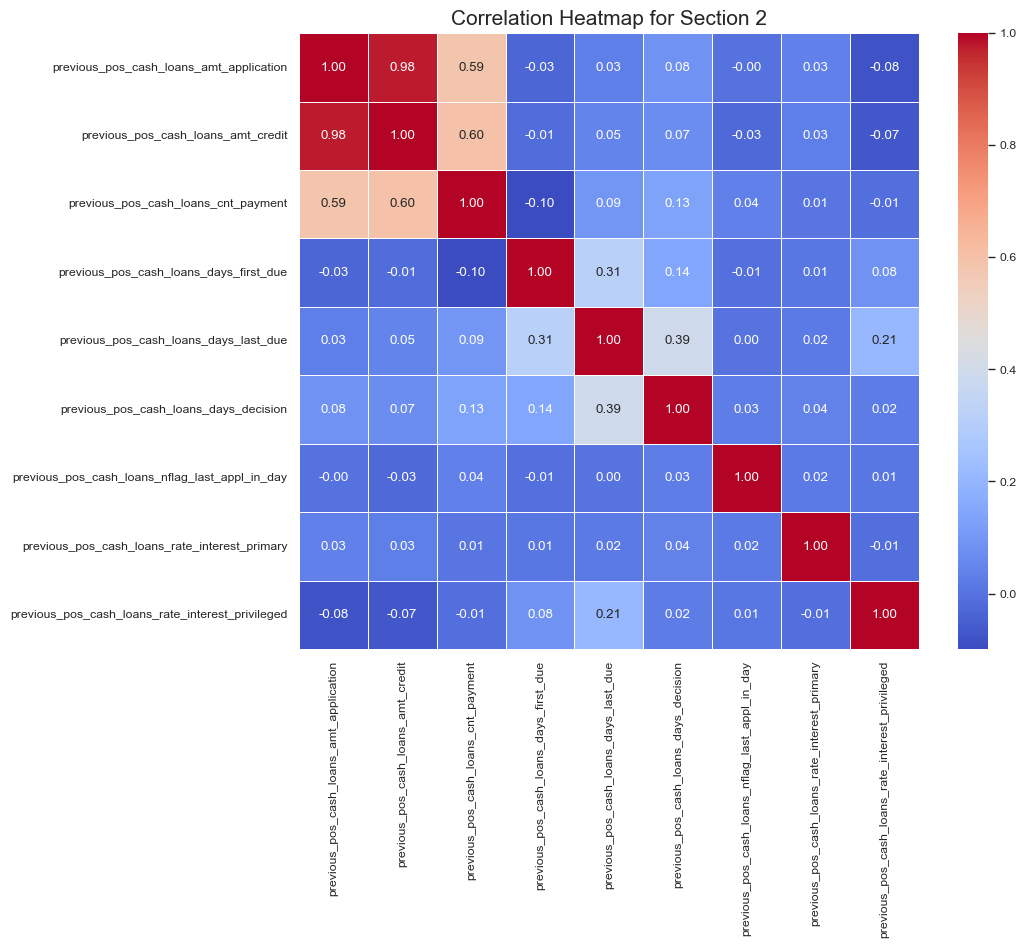

In [29]:
# Selecting key columns for the heatmap
key_columns = [
    'previous_pos_cash_loans_amt_application',
    'previous_pos_cash_loans_amt_credit',
    'previous_pos_cash_loans_cnt_payment',
    'previous_pos_cash_loans_days_first_due',
    'previous_pos_cash_loans_days_last_due',
    'previous_pos_cash_loans_days_decision',
    'previous_pos_cash_loans_nflag_last_appl_in_day',
    'previous_pos_cash_loans_rate_interest_primary',
    'previous_pos_cash_loans_rate_interest_privileged'
]

# Creating a correlation matrix for the selected columns
correlation_matrix = section2[key_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Section 2', fontsize=15)
plt.show()


#### - Distribution Plots

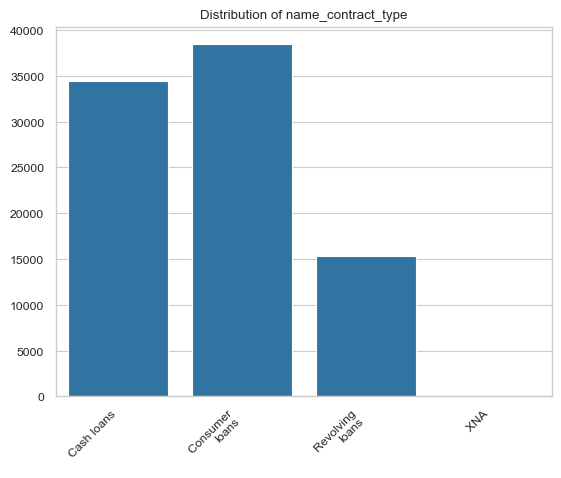

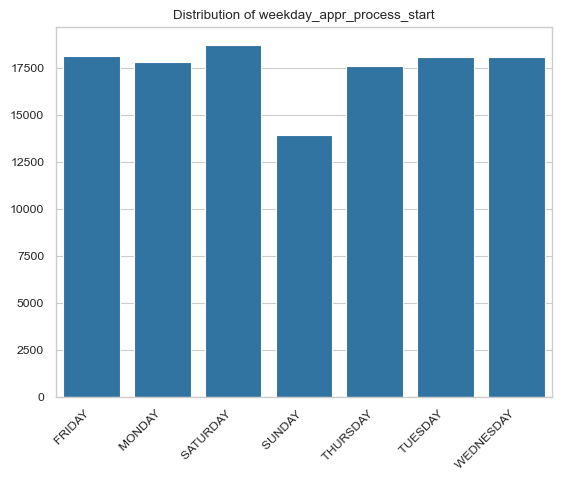

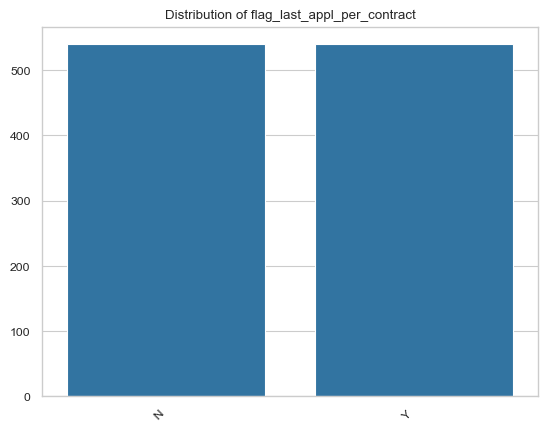

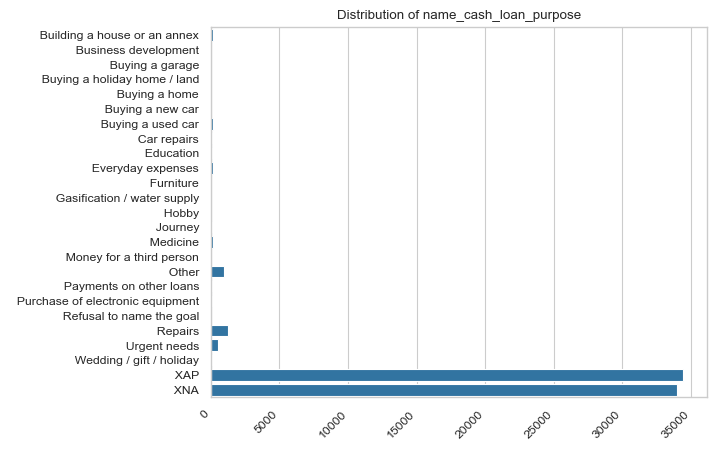

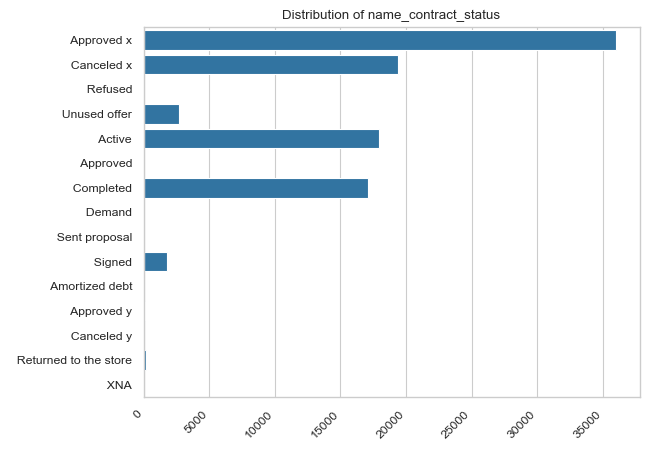

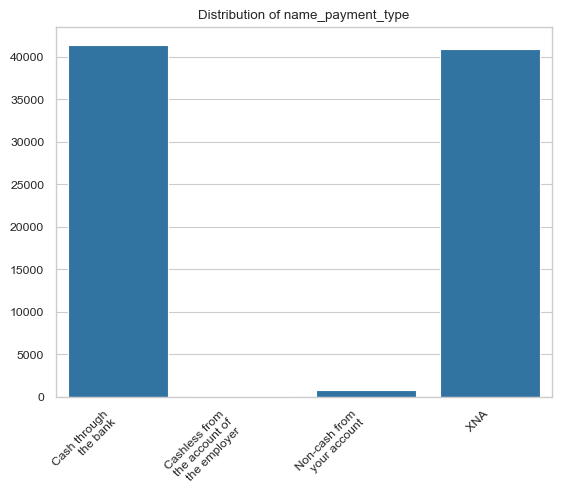

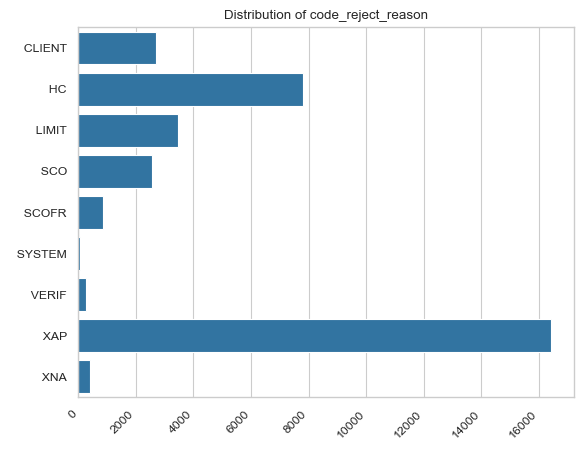

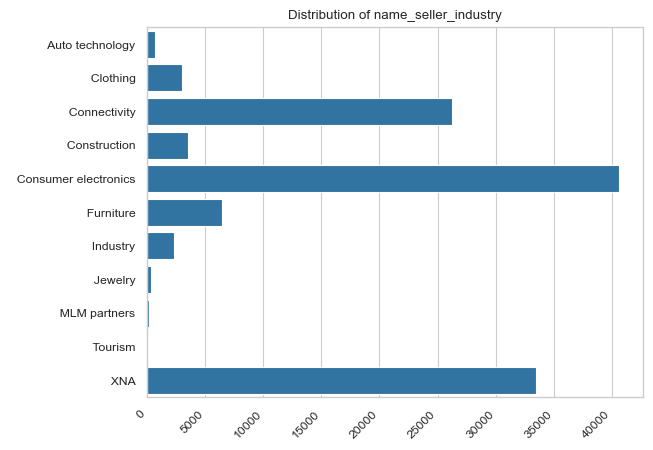

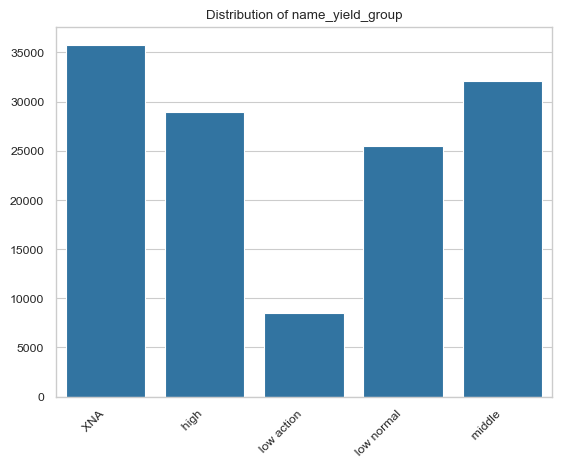

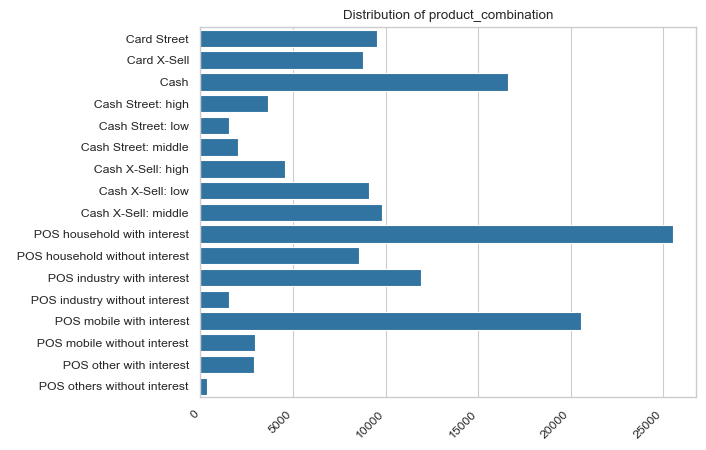

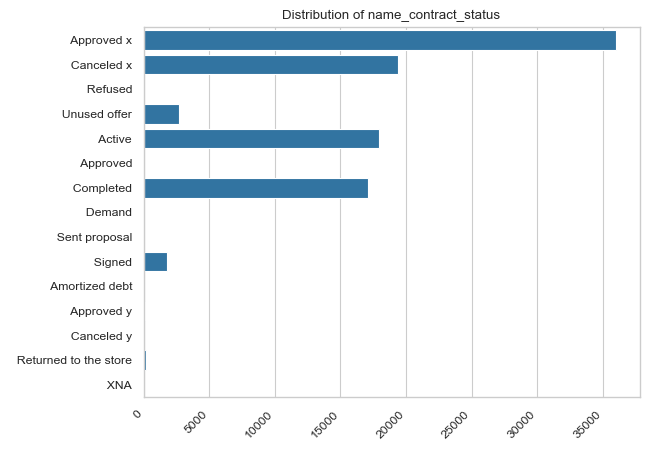

In [30]:


def plot_col_dummies(df: pd.DataFrame, col: str, orientation: str):
    cols = [x for x in df.columns if col in x]
    values = {(c.replace("previous_credit_cards", "").replace("previous_pos_cash_loans", "").replace(col, '')).replace("_", " "): df[c].value_counts().tolist()[1] for c in cols}

    if orientation == "v":
    
    # Wrap the column names to avoid long labels
        wrapped_labels = [textwrap.fill(label, width=15) for label in values.keys()]

        sb.barplot(x=wrapped_labels, y=list(values.values()), orient=orientation)
    else:
        sb.barplot(data = values, orient=orientation)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.show()

eda_section2_columns = ["name_contract_type", "weekday_appr_process_start", "flag_last_appl_per_contract",
                        "name_cash_loan_purpose", "name_contract_status", "name_payment_type",
                        "code_reject_reason", "name_seller_industry", "name_yield_group",
                        "product_combination", "name_contract_status"]


for column in eda_section2_columns:
    if column in ["name_contract_status", "name_cash_loan_purpose", "code_reject_reason", "name_seller_industry",
                        "product_combination", "name_contract_status"]:
        orientation = "h"
    else:
        orientation = "v"
    plot_col_dummies(section2, column, orientation)


### 3-EDA on Section 3

#### - General informations on Section 3

In [31]:
# Count of missing values for each column in the 'section3' DataFrame

section3.isna().sum()

sk_id_bureau                                                                      0
previous_credits_days_credit                                                      0
previous_credits_credit_day_overdue                                               0
previous_credits_days_credit_enddate                                           2585
previous_credits_days_enddate_fact                                            37656
previous_credits_amt_credit_max_overdue                                       92840
previous_credits_cnt_credit_prolong                                               0
previous_credits_amt_credit_sum                                                   2
previous_credits_amt_credit_sum_debt                                           8372
previous_credits_amt_credit_sum_limit                                         25308
previous_credits_amt_credit_sum_overdue                                           0
previous_credits_days_credit_update                                         

In [32]:
# Count the number of duplicated rows in the 'section3' DataFrame

section3.duplicated().sum()

0

In [33]:
# Display a concise summary of the 'section3' DataFrame

section3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 49 columns):
 #   Column                                                                     Non-Null Count   Dtype  
---  ------                                                                     --------------   -----  
 0   sk_id_bureau                                                               305811 non-null  float64
 1   previous_credits_days_credit                                               305811 non-null  float64
 2   previous_credits_credit_day_overdue                                        305811 non-null  float64
 3   previous_credits_days_credit_enddate                                       303226 non-null  Float64
 4   previous_credits_days_enddate_fact                                         268155 non-null  Float64
 5   previous_credits_amt_credit_max_overdue                                    212971 non-null  float32
 6   previous_credits_cnt_credit_prolong         

In [34]:
# Generate descriptive statistics for the 'section3' DataFrame

section3.describe()

sk_id_bureau  previous_credits_days_credit  \
count  3.058110e+05                 305811.000000   
mean   5.923271e+06                  -1083.802103   
std    5.275005e+05                    558.441124   
min    5.000002e+06                  -2922.000000   
25%    5.466406e+06                  -1431.000000   
50%    5.921346e+06                  -1052.500000   
75%    6.381642e+06                   -670.369318   
max    6.843454e+06                      0.000000   

       previous_credits_credit_day_overdue  \
count                        305811.000000   
mean                              0.965926   
std                              24.957209   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                            2776.000000   

       previous_credits_days_credit_enddate  \
count                              303226.0   
mean                             662.420814   
std                             3282.359178   
min                                -41875.0   
25%                                -697.525   
50%                             -131.788889   
75%                                   613.0   
max                                 31198.0   

       previous_credits_days_enddate_fact  \
count                            268155.0   
mean                          -967.018316   
std                            531.158694   
min                               -8376.5   
25%                          -1288.591667   
50%                                -926.4   
75%                           -573.666667   
max                                   0.0   

       previous_credits_amt_credit_max_overdue  \
count                             2.129710e+05   
mean                              5.004934e+03   
std                               2.856819e+05   
min                               0.000000e+00   
25%                               0.000000e+00   
50%                               0.000000e+00   
75%                               2.063745e+03   
max                               1.159872e+08   

       previous_credits_cnt_credit_prolong  previous_credits_amt_credit_sum  \
count                        305811.000000                     3.058090e+05   
mean                              0.007010                     3.807398e+05   
std                               0.062334                     8.792865e+05   
min                               0.000000                     0.000000e+00   
25%                               0.000000                     1.039616e+05   
50%                               0.000000                     1.972972e+05   
75%                               0.000000                     3.978647e+05   
max                               6.000000                     1.980724e+08   

       previous_credits_amt_credit_sum_debt  \
count                          2.974390e+05   
mean                           1.616341e+05   
std                            5.367677e+05   
min                           -1.083615e+06   
25%                            0.000000e+00   
50%                            4.476038e+04   
75%                            1.436004e+05   
max                            5.175000e+07   

       previous_credits_amt_credit_sum_limit  ...  \
count                           2.805030e+05  ...   
mean                            5.898539e+03  ...   
std                             2.992182e+04  ...   
min                            -9.789166e+04  ...   
25%                             0.000000e+00  ...   
50%                             0.000000e+00  ...   
75%                             0.000000e+00  ...   
max                             4.500000e+06  ...   

       previous_credits_credit_type_Microloan  \
count                           305811.000000   
mean                                 0.004743   
std                                  0.048951   
min                    

In [35]:
# General information on Missing Values

check_null = section3.isna().sum().sort_values(ascending=False)
percentage = ((section3.isnull().sum()/len(section3)*100)).sort_values(ascending=False)
isna_train = pd.concat([check_null, percentage], axis=1, keys=['Count','Percentage'])
print('Count and percentage of missing values:')
isna_train.head(20)

Count and percentage of missing values:


Count  Percentage
status_X_last                                       249378   81.546445
status_4_last                                       249378   81.546445
sk_id_bureau_first                                  249378   81.546445
months_balance_min                                  249378   81.546445
months_balance_max                                  249378   81.546445
status_0_last                                       249378   81.546445
status_2_last                                       249378   81.546445
status_3_last                                       249378   81.546445
status_1_last                                       249378   81.546445
status_C_last                                       249378   81.546445
status_5_last                                       249378   81.546445
previous_credits_amt_annuity                        187587   61.340828
previous_credits_amt_credit_max_overdue              92840   30.358620
previous_credits_days_enddate_fact                   37656   12.313488
previous_credits_amt_credit_sum_limit                25308    8.275700
previous_credits_amt_credit_sum_debt                  8372    2.737639
previous_credits_days_credit_enddate                  2585    0.845293
previous_credits_amt_credit_sum                          2    0.000654
previous_credits_credit_type_Loan for purchase ...       0    0.000000
sk_id_curr                                               0    0.000000

#### - Heatmap of correlations

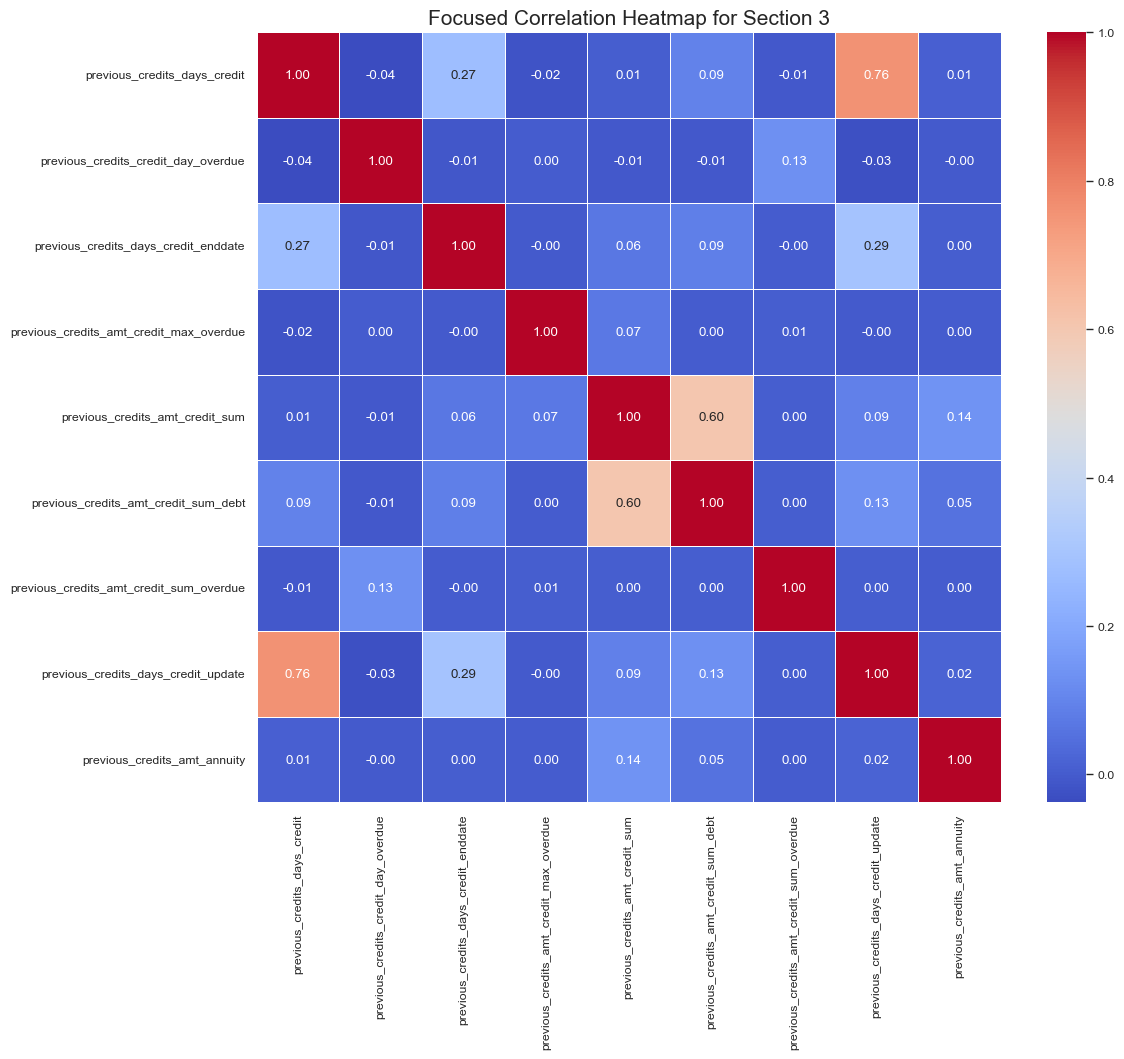

In [60]:
key_columns = [
    'previous_credits_days_credit',
    'previous_credits_credit_day_overdue',
    'previous_credits_days_credit_enddate',
    'previous_credits_amt_credit_max_overdue',
    'previous_credits_amt_credit_sum',
    'previous_credits_amt_credit_sum_debt',
    'previous_credits_amt_credit_sum_overdue',
    'previous_credits_days_credit_update',
    'previous_credits_amt_annuity',
]

# Creating a correlation matrix for the selected columns
correlation_matrix = section3[key_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Focused Correlation Heatmap for Section 3', fontsize=15)
plt.show()

#### - Distribution Plots

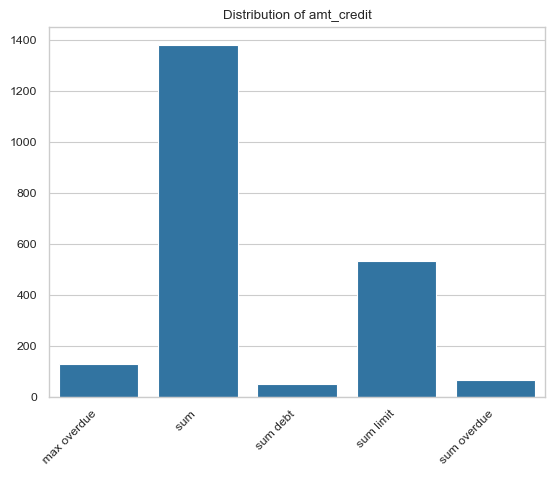

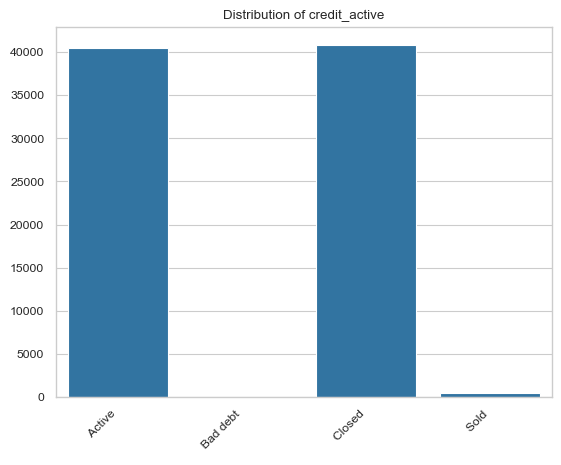

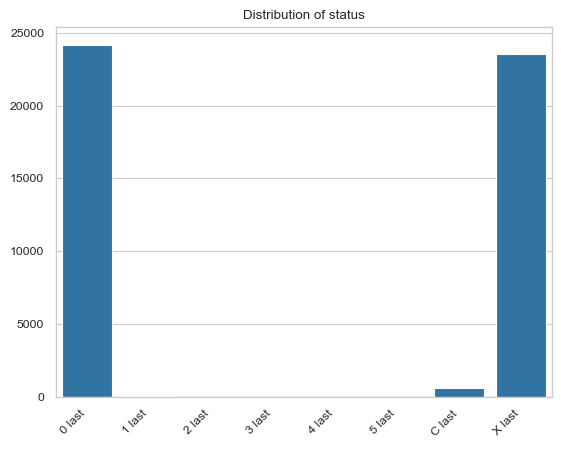

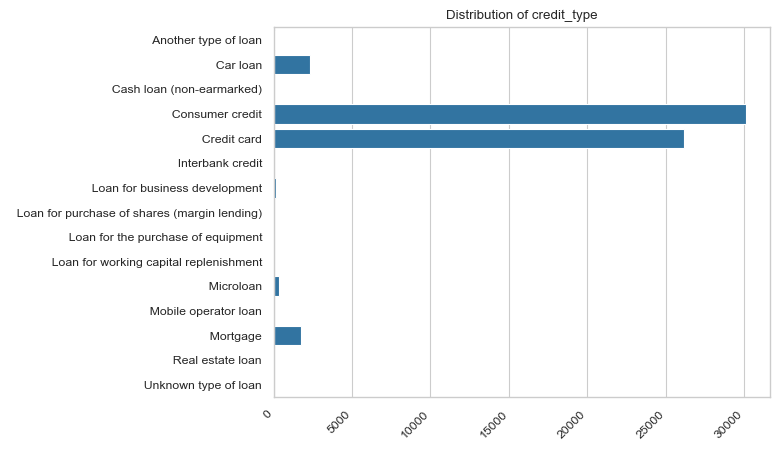

In [37]:
def plot_col_dummies(df: pd.DataFrame, col: str, orientation: str):
    cols = [x for x in df.columns if col in x]
    values = {(c.replace("previous_credits", "").replace(col, '')).replace("_", " "): df[c].value_counts().tolist()[1] for c in cols}

    if orientation == "v":
    
    # Wrap the column names to avoid long labels
        wrapped_labels = [textwrap.fill(label, width=15) for label in values.keys()]

        sb.barplot(x=wrapped_labels, y=list(values.values()), orient=orientation)
    else:
        sb.barplot(data = values, orient=orientation)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.show()

eda_section3_columns = ["amt_credit", "credit_active","status", "credit_type"]


for column in eda_section3_columns:
    if column == "credit_type":
        orientation = "h"
    else:
        orientation = "v"
    plot_col_dummies(section3, column, orientation)

## F-Visualization Development

### 1-Percentage of target 1 and target 0 in each category

In [38]:
original_column_names = ["name_type_suite", "name_income_type", "name_education_type", "name_family_status",
                        "code_gender", "name_contract_type", "flag_own_car", "flag_own_realty",
                        "name_contract_type", "weekday_appr_process_start", "flag_last_appl_per_contract",
                        "name_cash_loan_purpose", "name_contract_status", "name_payment_type",
                        "code_reject_reason", "name_seller_industry", "name_yield_group",
                        "product_combination", "name_contract_status",
                        "amt_credit", "credit_active","status", "credit_type"]
original_columns = {}
for original_column in original_column_names:
    # Filter the DataFrame's columns to get the dummy columns for the original column
    dummy_columns = [column for column in full.columns if column.__contains__(original_column + '_')]

    # Add the original column name and the list of dummy columns to the dictionary
    original_columns[original_column] = dummy_columns

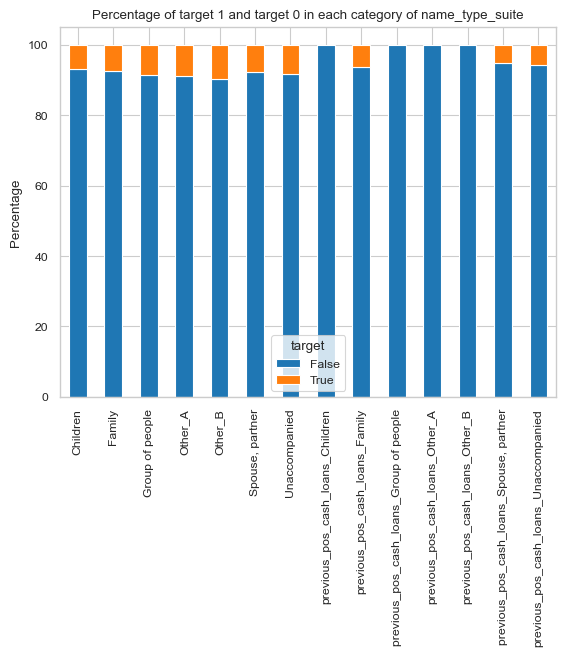

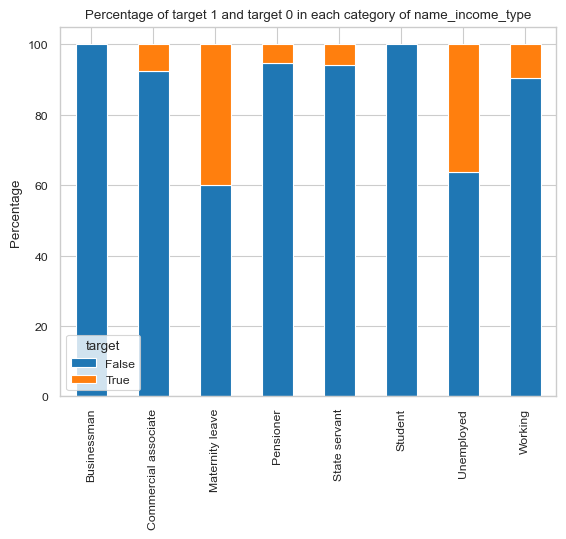

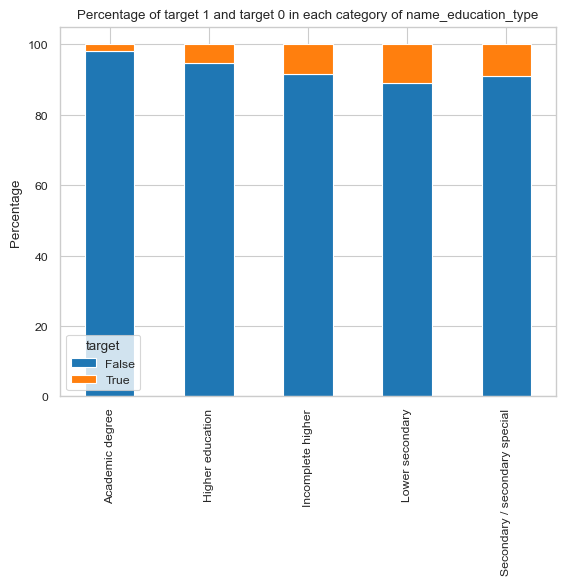

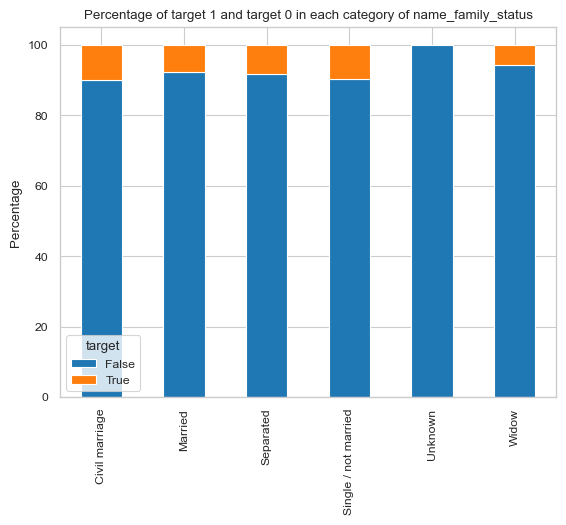

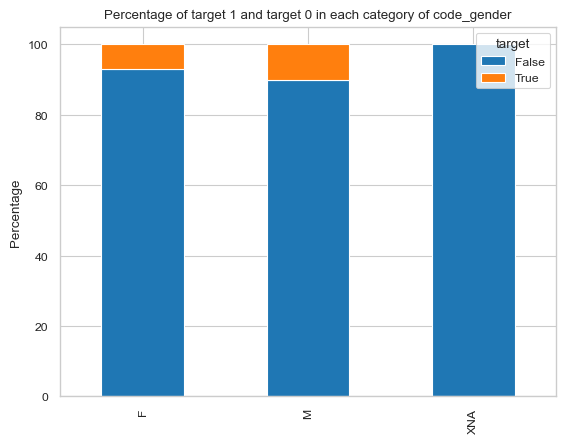

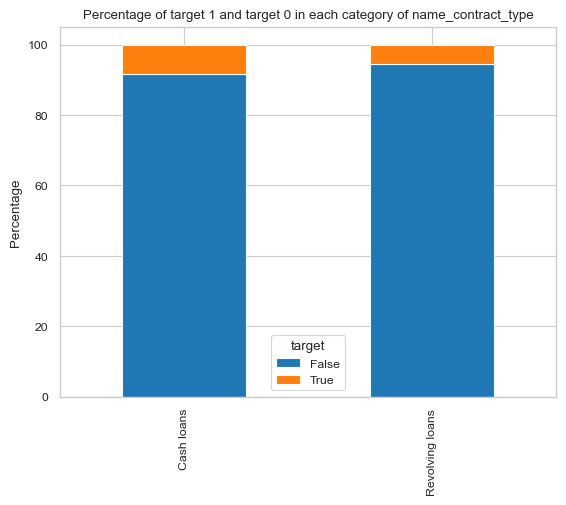

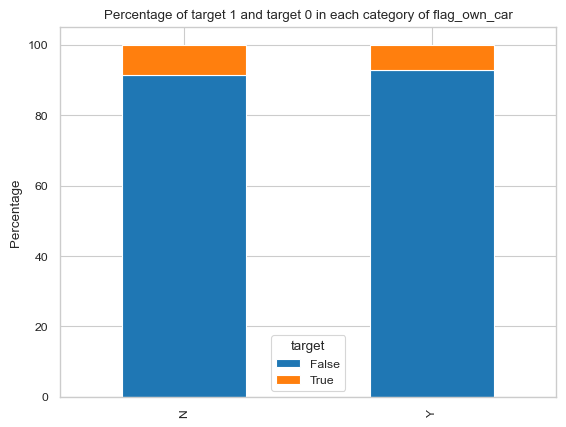

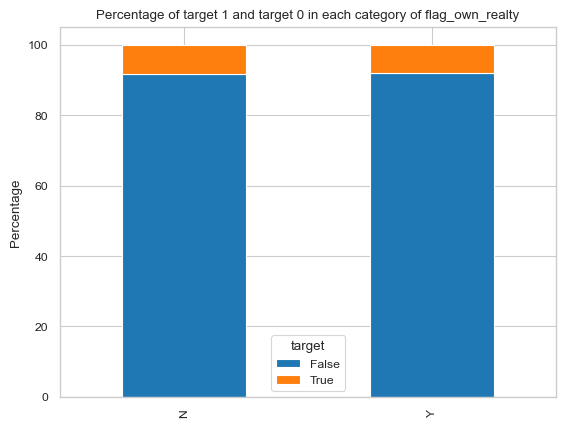

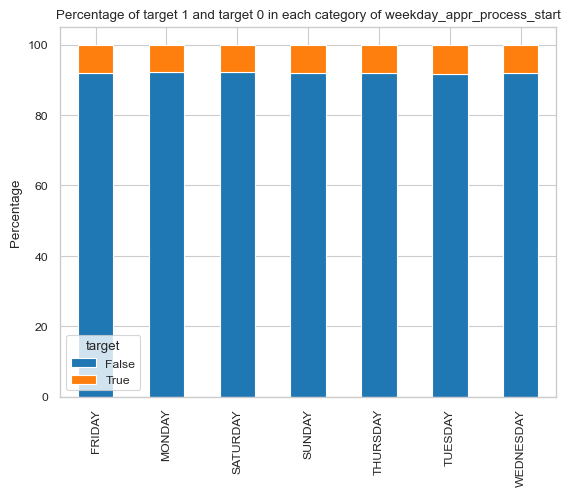

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


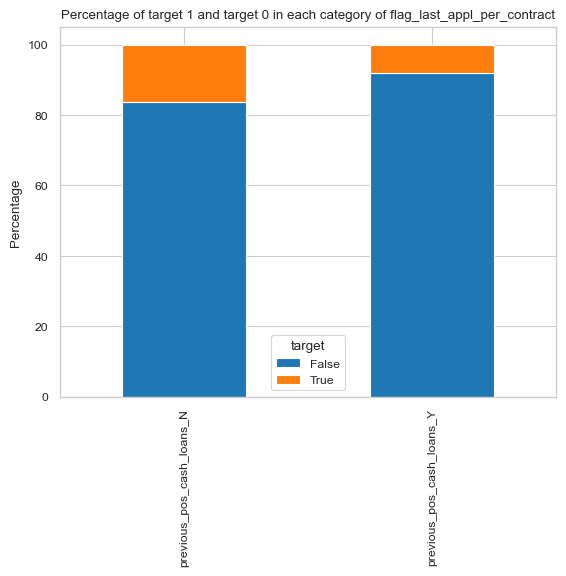

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


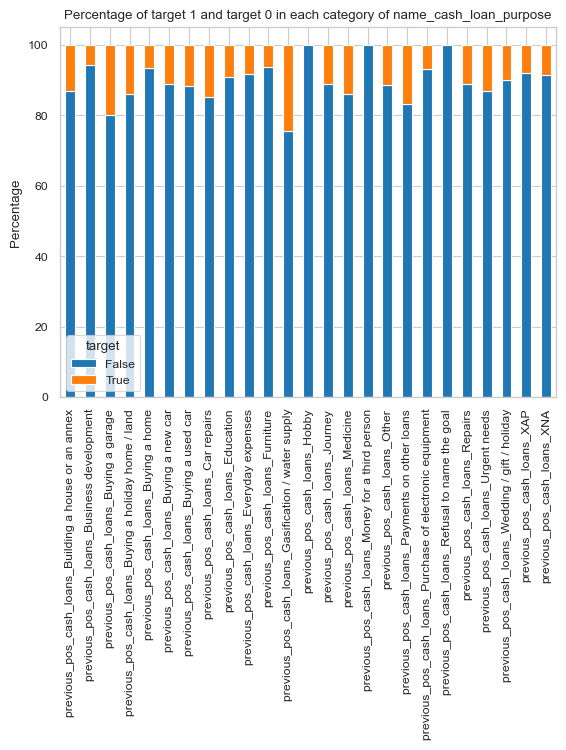

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


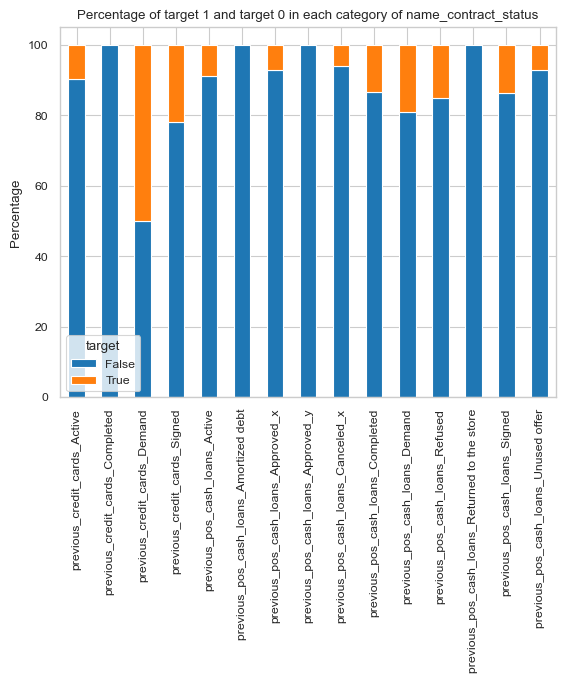

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


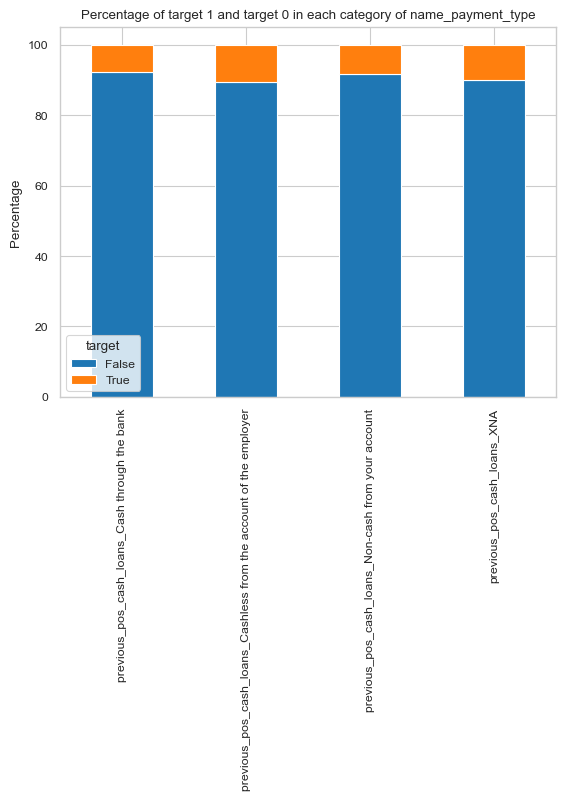

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


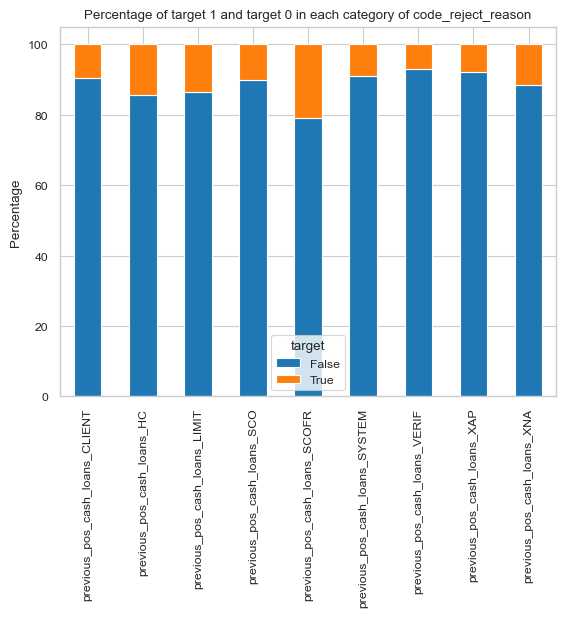

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


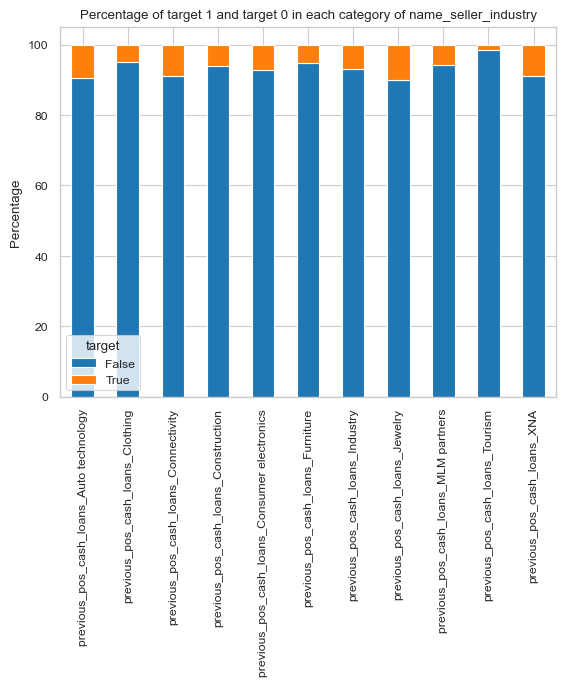

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


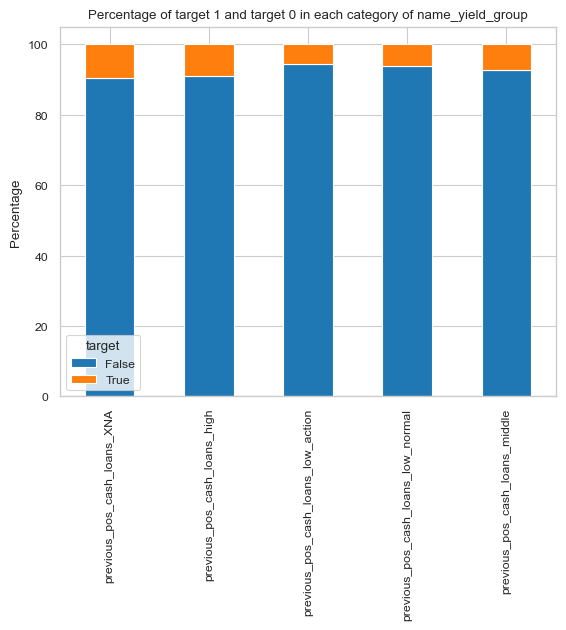

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


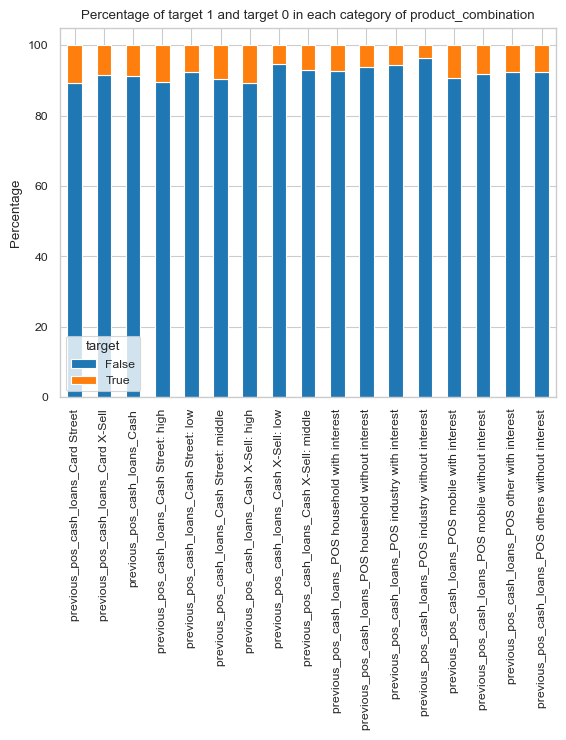

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


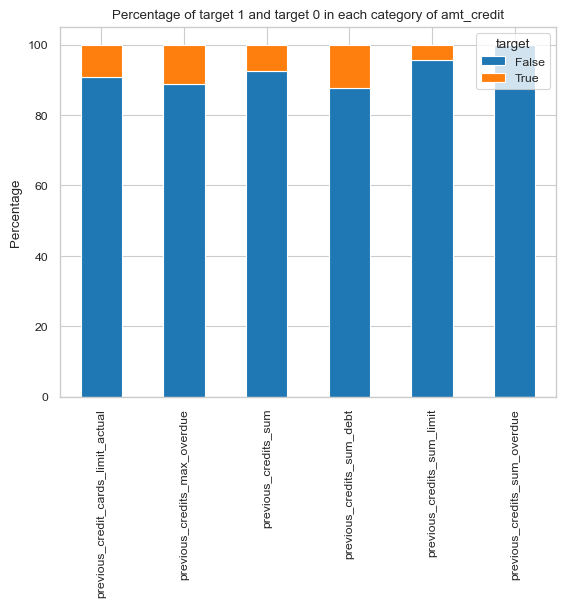

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


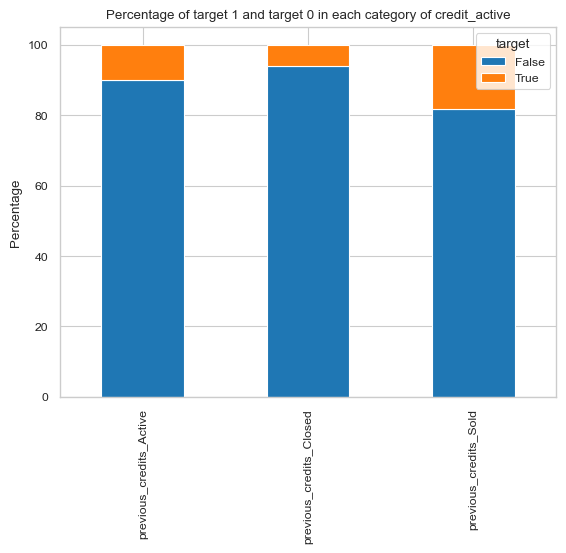

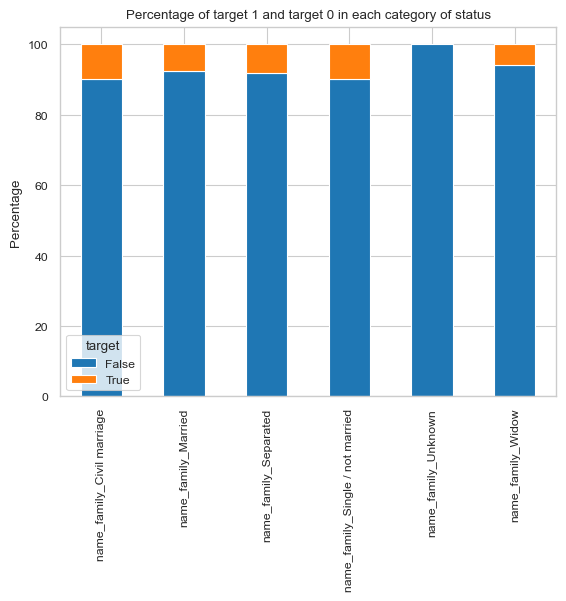

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3404893474.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  combined = full[dummy_columns].idxmax(axis=1)


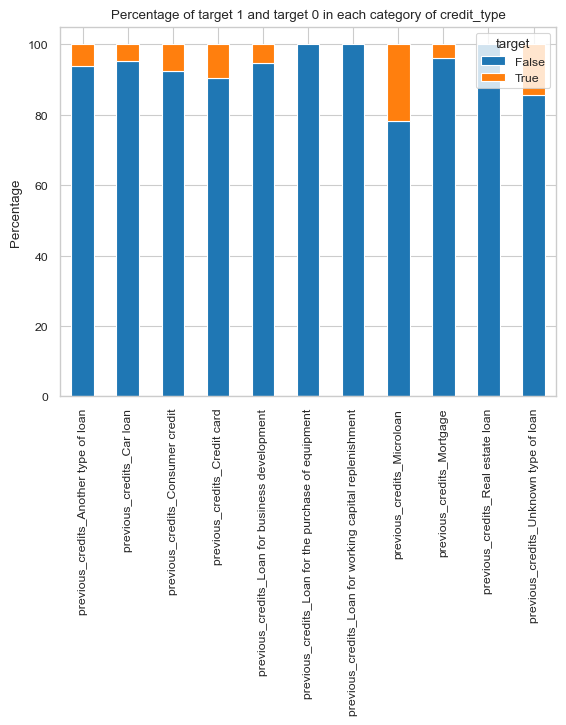

In [39]:
for original_column, dummy_columns in original_columns.items():
    # Combine the dummy columns into a single Series
    combined = full[dummy_columns].idxmax(axis=1)

    # Group by the combined Series and the target column, and calculate the size of each group
    group_sizes = full.groupby([combined, 'target']).size()

    # Normalize the group sizes to get the percentage of each group
    group_percentages = group_sizes.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

    # Plot the percentages in a bar plot
    ax = group_percentages.unstack().plot(kind='bar', stacked=True)

    # Apply the function to the index of the group_percentages Series to get the new labels
    labels = ax.get_xticklabels()
    new_labels = hf.modify_labels(original_column, labels)

    plt.xticks(range(len(new_labels)), new_labels, rotation='vertical')

    plt.ylabel('Percentage')
    plt.title(f'Percentage of target 1 and target 0 in each category of {original_column}')
    plt.show()

### 2-Correlation Heatmap with Target

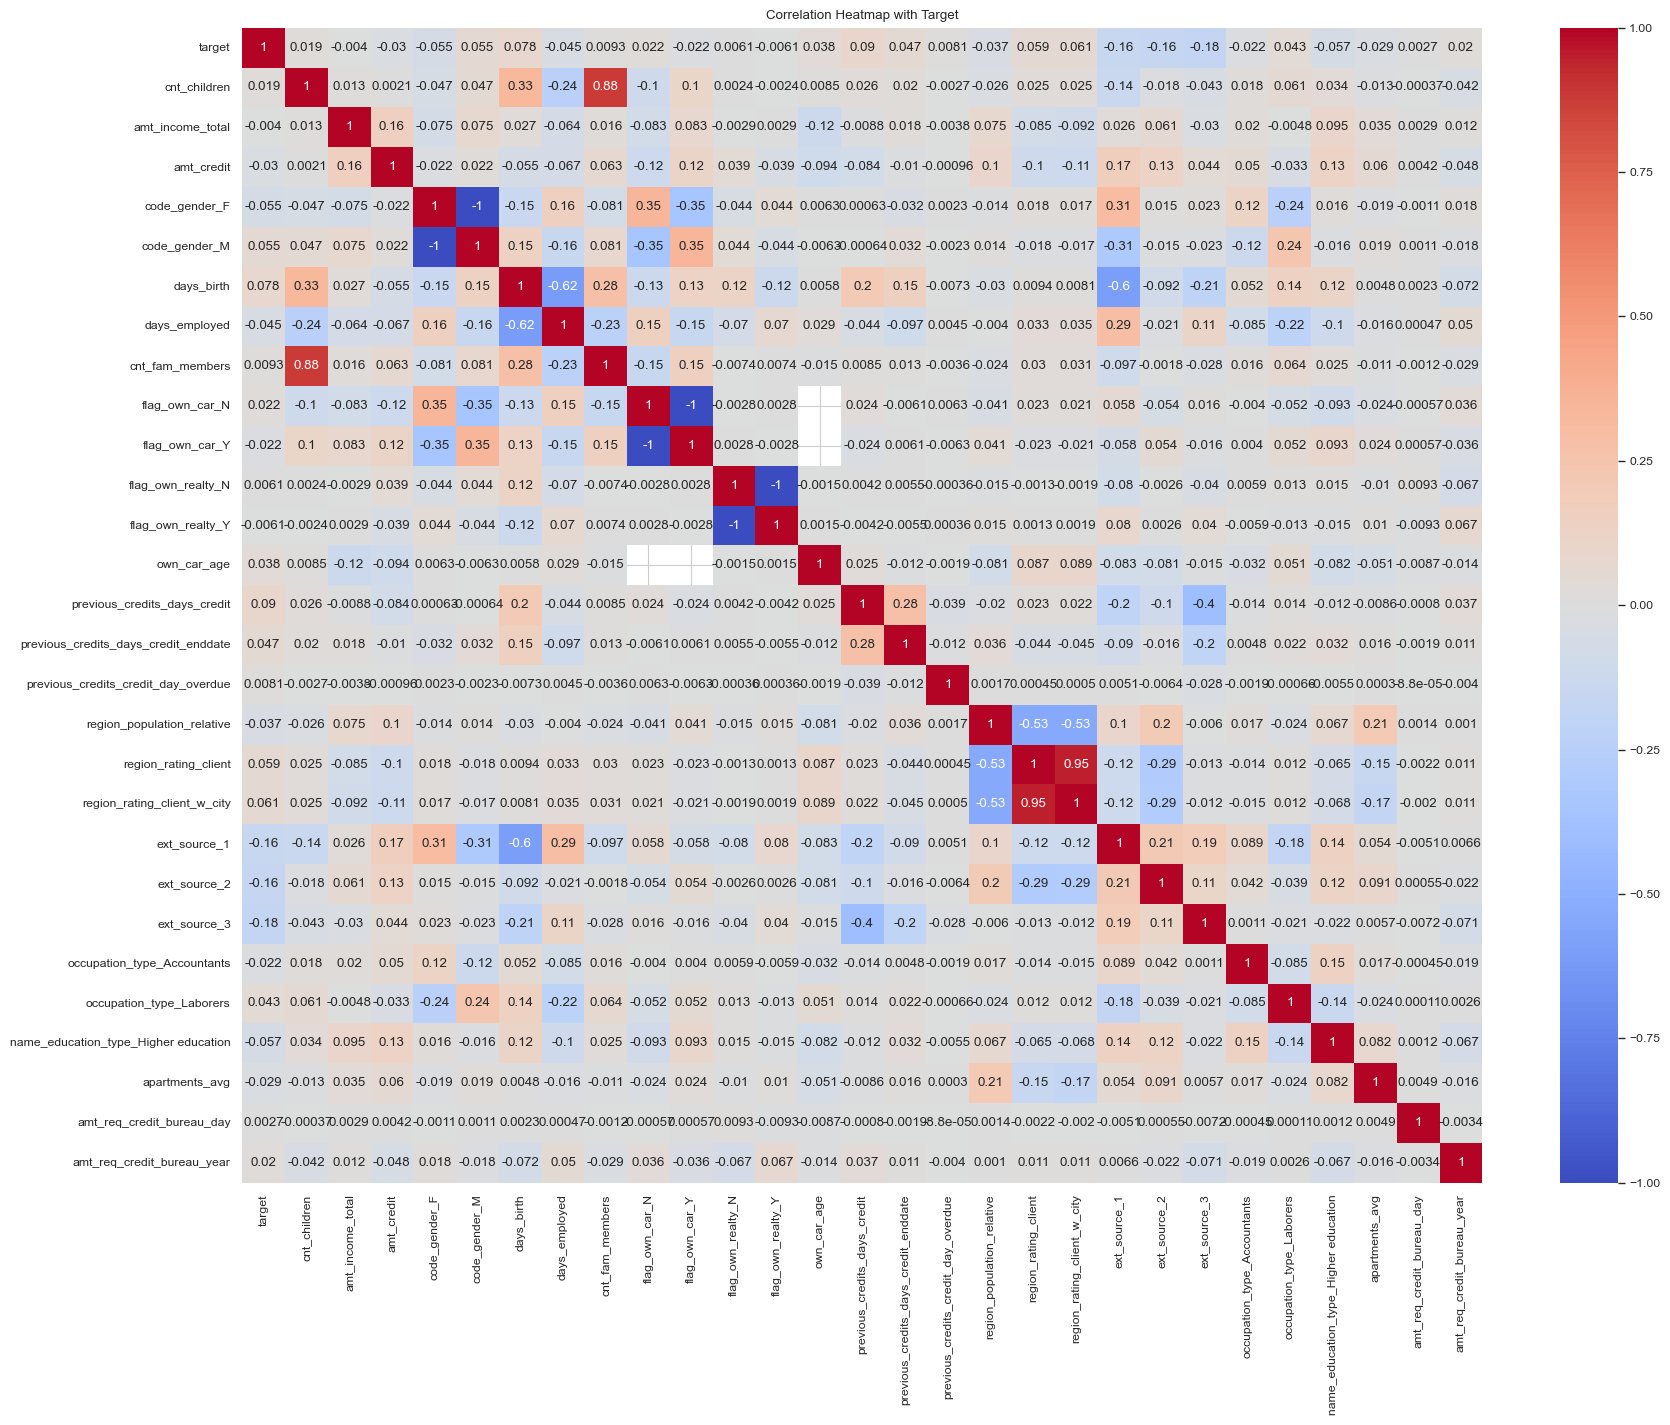

In [55]:
# Calculate the correlation matrix between important columns and the target variable
selected_columns = [
    'target','cnt_children','amt_income_total','amt_credit','code_gender_F','code_gender_M', 'days_birth','days_employed','cnt_fam_members','flag_own_car_N','flag_own_car_Y','flag_own_realty_N','flag_own_realty_Y',
    'own_car_age','previous_credits_days_credit', 'previous_credits_days_credit_enddate','previous_credits_credit_day_overdue', 'region_population_relative','region_rating_client','region_rating_client_w_city',
    'ext_source_1','ext_source_2','ext_source_3','occupation_type_Accountants','occupation_type_Laborers','name_education_type_Higher education','apartments_avg','amt_req_credit_bureau_day','amt_req_credit_bureau_year'
]

correlation_matrix = full[selected_columns].corr()

# Create the heatmap
plt.figure(figsize=(20, 15))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Target')
plt.show()

### 3-Scatter Plot

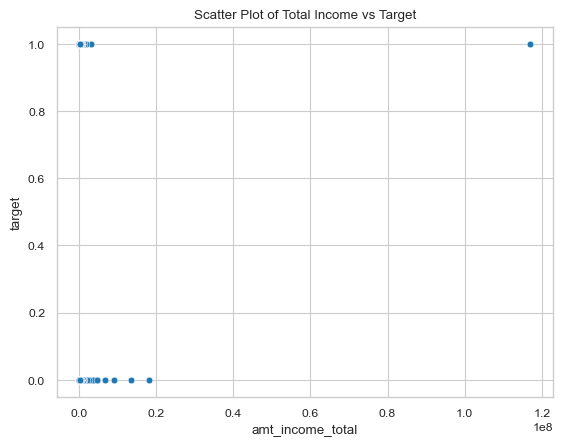

In [41]:
sb.scatterplot(data=full, x='amt_income_total', y='target')
plt.title('Scatter Plot of Total Income vs Target')
plt.show()

### 4-Pair Plot

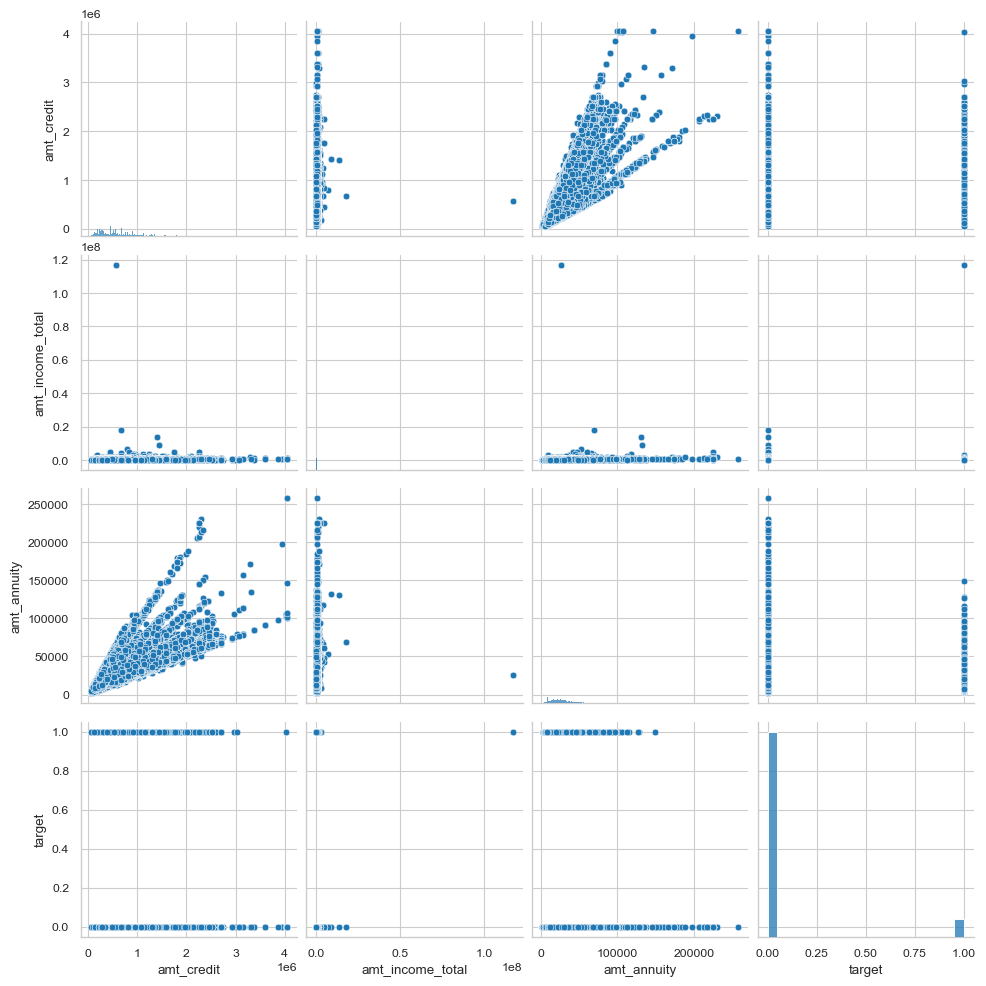

In [42]:
sb.pairplot(full[['amt_credit', 'amt_income_total', 'amt_annuity', 'target']])

### 5-Box Plots

#### - Box plot 1 : *cnt_children* vs *target*

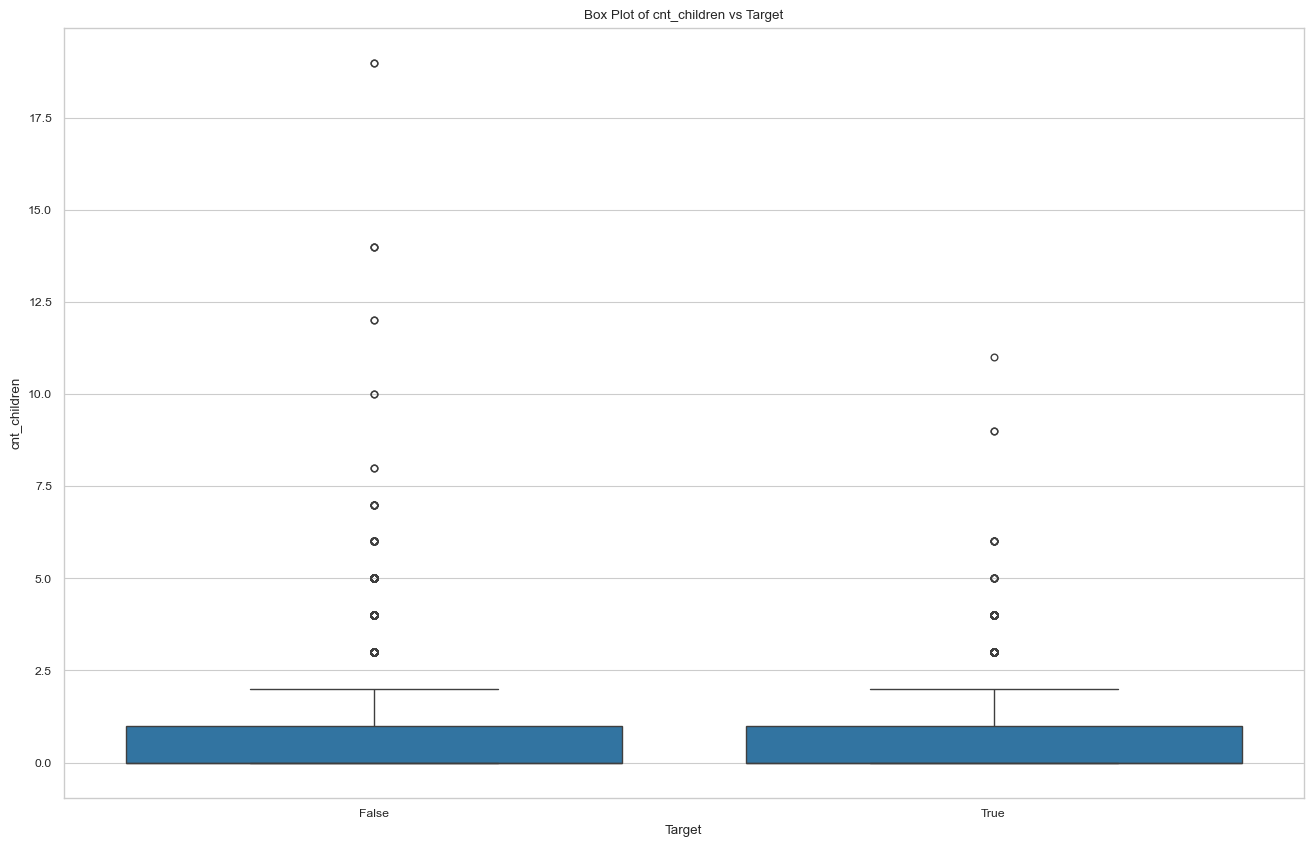

In [56]:
# Define the list of important columns
important_columns = [
    'cnt_children','amt_income_total','amt_credit','code_gender_F','code_gender_M','days_birth','days_employed','cnt_fam_members','flag_own_car_N','flag_own_car_Y','flag_own_realty_N','flag_own_realty_Y','own_car_age',
    'previous_credits_days_credit','previous_credits_days_credit_enddate','previous_credits_credit_day_overdue','region_population_relative','region_rating_client','region_rating_client_w_city','ext_source_1','ext_source_2','ext_source_3',
    'occupation_type_Accountants','occupation_type_Laborers', 'name_education_type_Higher education','apartments_avg','amt_req_credit_bureau_day','amt_req_credit_bureau_year'
]

# Create a single box plot for each important column with respect to the target
plt.figure(figsize=(16, 10))
sb.boxplot(data=full, x='target', y=important_columns[0])
plt.xticks([0, 1], ['False', 'True'])
plt.xlabel('Target')
plt.ylabel(important_columns[0])
plt.title(f'Box Plot of {important_columns[0]} vs Target')
plt.show()


#### - Box plot 2 : *amt_credit* vs *target*

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\1759836445.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='target', y='amt_credit', data=full, palette = 'ch:start=0.2,rot=-.3_r')


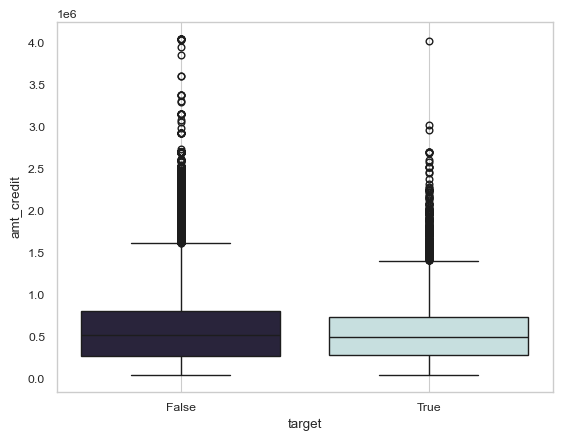

In [44]:
sb.boxplot(x='target', y='amt_credit', data=full, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

#### - Box plot 3 : *amt_income_total* vs *target*

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\704362604.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='target', y='amt_income_total', data=full, palette = 'ch:start=0.2,rot=-.3_r')


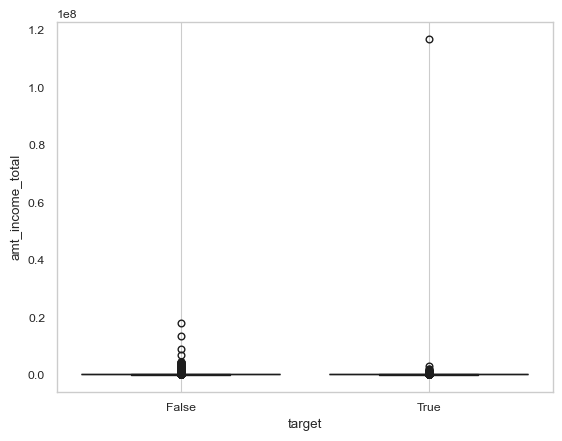

In [45]:
sb.boxplot(x='target', y='amt_income_total', data=full, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

### 6-Histogram plot : *Credit Amount*

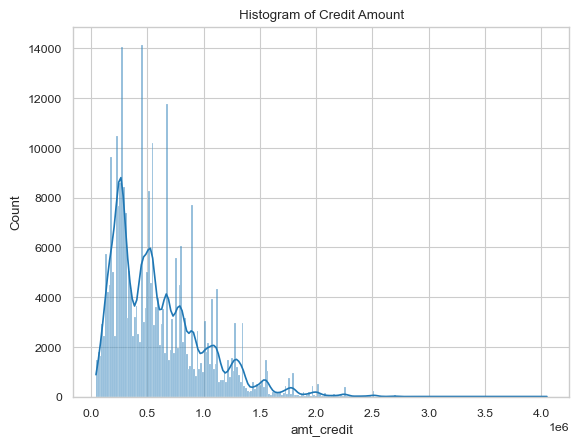

In [46]:
sb.histplot(full['amt_credit'], kde=True)
plt.title('Histogram of Credit Amount')
plt.show()

### 7-Violin Plot : Credit amount by Target

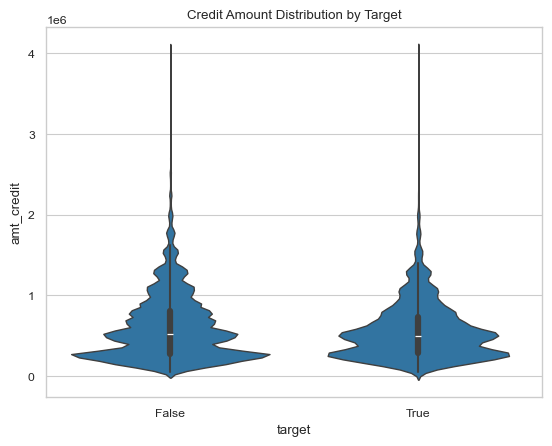

In [47]:
sb.violinplot(x='target', y='amt_credit', data=full)
plt.title('Credit Amount Distribution by Target')
plt.show()

### 8- Barplot

#### - Average Credit Amount by Family Status and Target

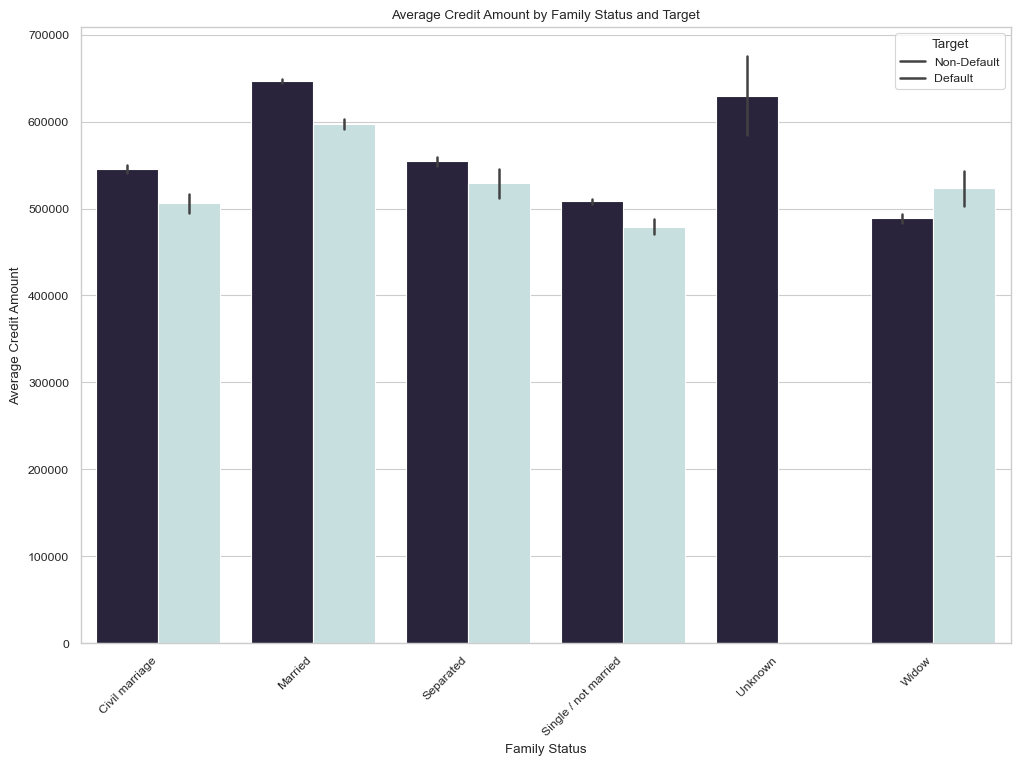

In [48]:
# Melt the DataFrame to get 'name_family_status' in a single column
melted_full = full.melt(id_vars=['target', 'amt_credit'],
                        value_vars=['name_family_status_Civil marriage',
                                    'name_family_status_Married',
                                    'name_family_status_Separated',
                                    'name_family_status_Single / not married',
                                    'name_family_status_Unknown',
                                    'name_family_status_Widow'],
                        var_name='name_family_status',
                        value_name='status_value')

# Filter to include only rows where status_value is true/1
melted_full = melted_full[melted_full['status_value'] == 1]

# Rename 'name_family_status' to remove prefix for readability
melted_full['name_family_status'] = melted_full['name_family_status'].str.replace('name_family_status_', '')

# Create the combined bar plot
plt.figure(figsize=(12, 8))
sb.barplot(x='name_family_status', y='amt_credit', hue='target',
            data=melted_full, palette='ch:start=0.2,rot=-.3_r')

# Set the rotation of x-axis labels and other plot details
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Family Status')
plt.ylabel('Average Credit Amount')
plt.title('Average Credit Amount by Family Status and Target')
plt.legend(title='Target', labels=['Non-Default', 'Default'])

plt.show()


#### - Average Credit Amount by Region Rating and Target

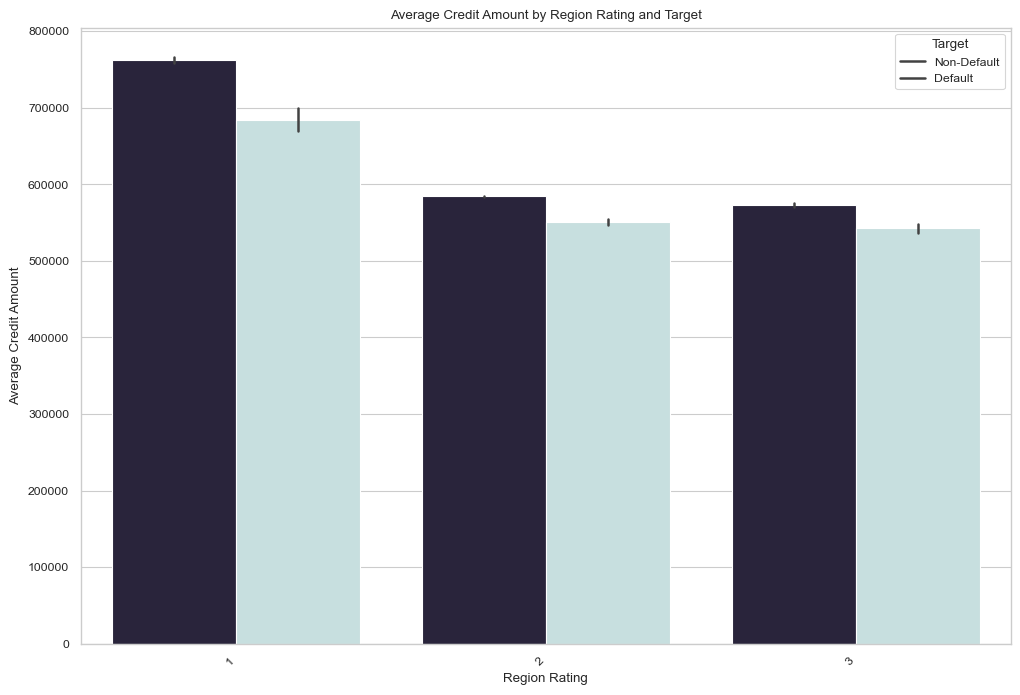

In [49]:
# Melt the DataFrame to get 'region_rating_client' and 'region_rating_client_w_city' in long format
melted_full = full.melt(id_vars=['target', 'amt_credit'],
                        value_vars=['region_rating_client', 'region_rating_client_w_city'],
                        var_name='region_rating_type',
                        value_name='region_rating')

# Create the combined bar plot
plt.figure(figsize=(12, 8))
sb.barplot(x='region_rating', y='amt_credit', hue='target',
            data=melted_full, palette='ch:start=0.2,rot=-.3_r')

# Set the rotation of x-axis labels and other plot details
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Region Rating')
plt.ylabel('Average Credit Amount')
plt.title('Average Credit Amount by Region Rating and Target')
plt.legend(title='Target', labels=['Non-Default', 'Default'])

plt.show()

### 9- Catplot

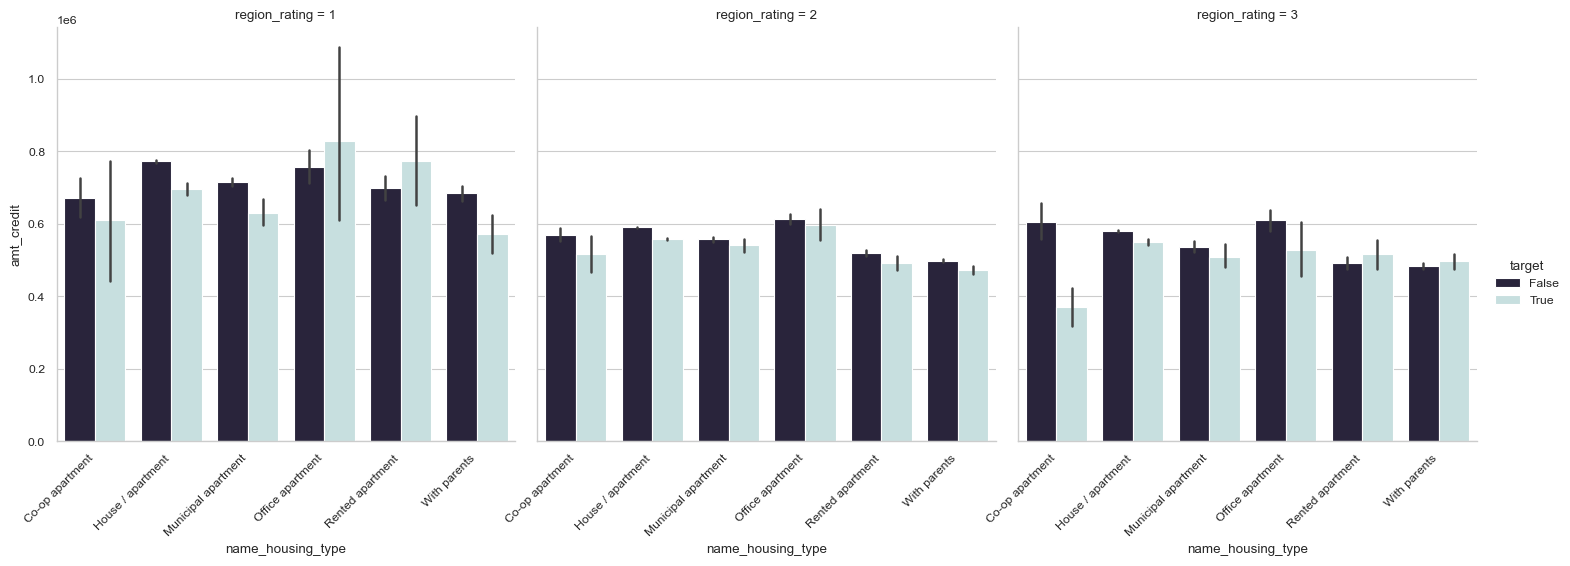

In [50]:
# Melt for 'name_housing_type'
melted_housing = full.melt(id_vars=['target', 'amt_credit',
                                    'region_rating_client', 'region_rating_client_w_city'],
                           value_vars=['name_housing_type_Co-op apartment',
                                       'name_housing_type_House / apartment',
                                       'name_housing_type_Municipal apartment',
                                       'name_housing_type_Office apartment',
                                       'name_housing_type_Rented apartment',
                                       'name_housing_type_With parents'],
                           var_name='name_housing_type',
                           value_name='housing_status')

# Filter to include only rows where housing_status is true/1
melted_housing = melted_housing[melted_housing['housing_status'] == 1]

# Rename 'name_housing_type' to remove prefix
melted_housing['name_housing_type'] = melted_housing['name_housing_type'].str.replace('name_housing_type_', '')

# Separate melted data for 'region_rating_client' and 'region_rating_client_w_city'
melted_rating = melted_housing.melt(id_vars=['target', 'amt_credit', 'name_housing_type'],
                                    value_vars=['region_rating_client', 'region_rating_client_w_city'],
                                    var_name='region_rating_type',
                                    value_name='region_rating')

# Concatenate the melted data
final_melted = pd.concat([melted_rating[melted_rating['region_rating_type'] == 'region_rating_client'],
                          melted_rating[melted_rating['region_rating_type'] == 'region_rating_client_w_city']])

# Create the categorical plot
fig = sb.catplot(x='name_housing_type',
                  y='amt_credit',
                  hue='target',
                  col='region_rating',
                  kind='bar',
                  palette='ch:start=0.2,rot=-.3_r',
                  data=final_melted)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()


### 10- Histplot

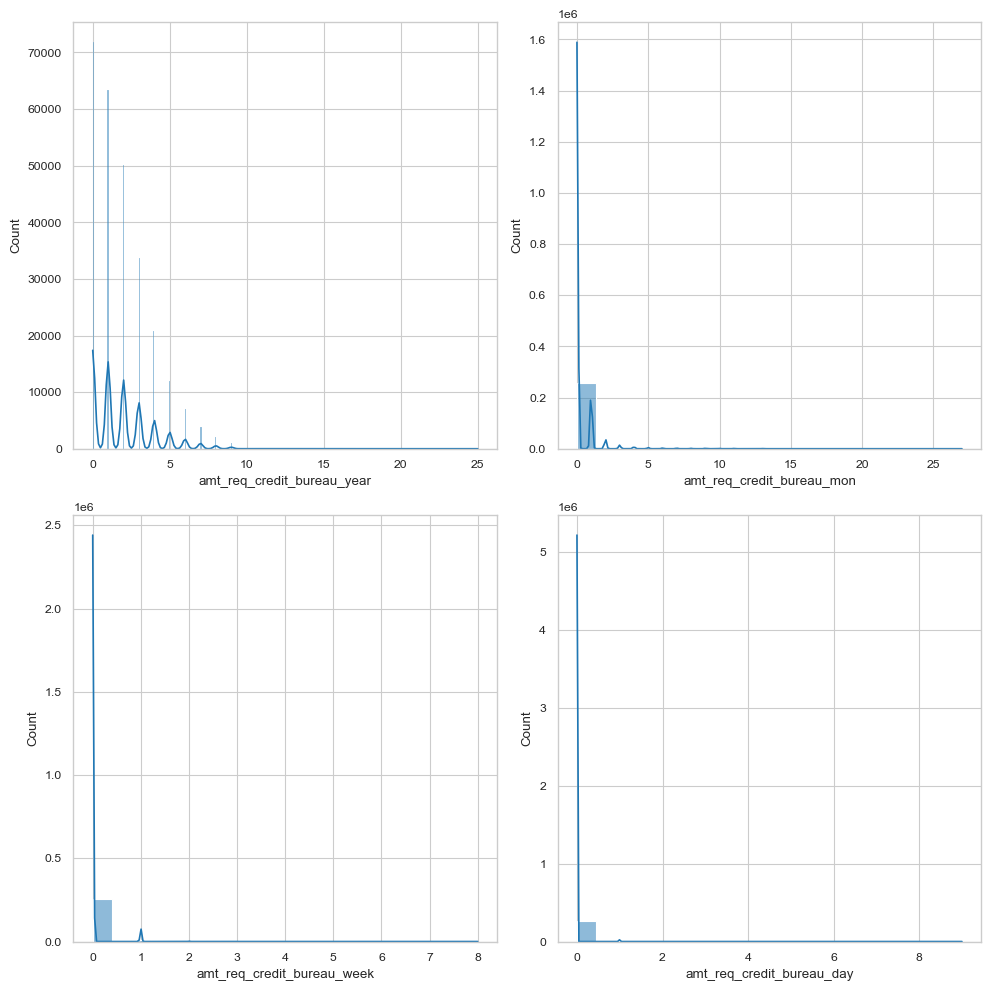

In [51]:
sb.set_style('whitegrid')
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sb.set_context('paper', font_scale=1)

# Excluding NaN values before plotting
sb.histplot(full['amt_req_credit_bureau_year'].dropna(), ax=ax[0][0], kde=True)
sb.histplot(full['amt_req_credit_bureau_mon'].dropna(), ax=ax[0][1], kde=True)
sb.histplot(full['amt_req_credit_bureau_week'].dropna(), ax=ax[1][0], kde=True)
sb.histplot(full['amt_req_credit_bureau_day'].dropna(), ax=ax[1][1], kde=True)

plt.tight_layout()
plt.show()

### 11- Distplot

#### - Distrubtion of *amt_credit*

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\1778707446.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sb.distplot(full["amt_credit"])


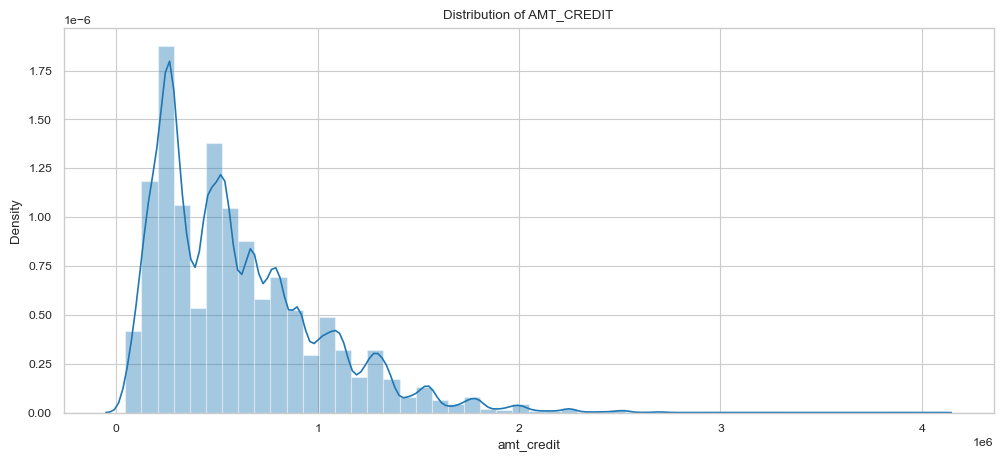

In [58]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sb.distplot(full["amt_credit"])

#### - Distrubtion of *amt_annuity*

C:\Users\Student\AppData\Local\Temp\ipykernel_6788\3179328039.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sb.distplot(full["amt_annuity"].dropna())


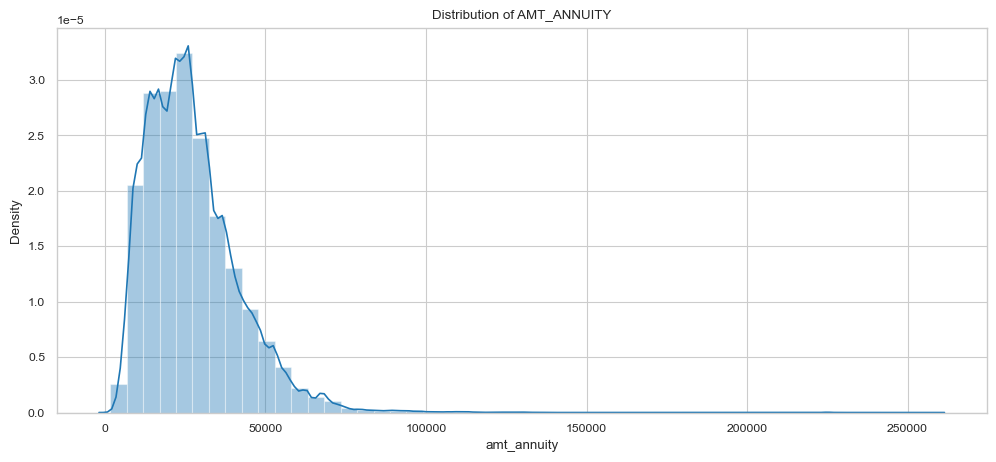

In [59]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_ANNUITY")
ax = sb.distplot(full["amt_annuity"].dropna())

## G-Conclusion

### **Key Findings:**

#### *Promising Borrower Profiles:*
- Maternity leave/unemployed
- Lower secondary education
- Married, males
- Gasification/water supply or garage loans
- Microloans
- Jewelry/connectivity/auto tech sellers

#### *Potentially Risky Profiles:*
- Real estate/equipment/capital replenishment/mortgage loans
- Widows
- Unspecified/hobby/furniture loan purposes
- Academic degrees
- Student/businessman/state servant/pensioner income

### **Recommendations:**

1. Prioritize microloans for essential needs and specific industries with strong repayment records.
2. Apply stricter criteria for risky credit types and loan purposes.
3. Consider alternative data sources for enhanced risk assessment.
4. Develop customized loan products for varying borrower profiles.

### **Implications:**

- *Data-driven insights* can significantly improve loan approval processes and reduce defaults.
- Continuous model refinement and adaptation are crucial for *responsible lending practices*.
- Customized loan products can promote *financial inclusion* and *responsible borrowing*.

